# Art Price Prediction Belgian Paintings

Using different Machine Learning algorithms, the price of paintings for a selected group of belgian painters will be forecasted.

Through web scraping the website of the biggest auction house turnover wise Christie's, the data is gathered ranging from artist, title, style, ... to the hue contrast in the painting, ... 

## Business Problem

The estimated price of a painting that is to be sold in these auction houses is not accurate enough. By using Machine Learning algorithms, the accuracy of the forecast of the art price is tried to be improved.

The estimated price of paintings set to be sold at these auction houses lacks sufficient accuracy. Machine learning algorithms are being employed in an attempt to enhance the precision of art price forecasting.

## Data exploration and preparation

- How many data instances do you have?
- Do you have duplicates?
- How many features? What type are they?
- If they are categorical, what categories they have, what is their frequency?
- If they are numerical, what is their distribution?
- What is the distribution of the target variable?
- If you have a target, you can also check the relationship between the target and the variables.
- Do you have missing data? If yes, how are you going to handle it?
- Can you use the features in their original form, or do you need to alter them in some way?

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import requests
warnings.filterwarnings("ignore")

#### import dataset

In [2]:
df = pd.read_csv('dataset_twee.csv')
df.head(2)

,Unnamed: 0,index,artist,img_name,collection,title,details,provenance,exhibit,further_details,price_realized,estimated_price,faces,heigth,width,contrast,brightness,dominant_color_hex,hue
0,0,0,James Ensor,2021_CKS_20068_0032_000(james_ensor_pierrot_et...,JAMES ENSOR (1860-1949),Pierrot et squelettes,JAMES ENSOR (1860-1949)Pierrot et squelettessi...,"Private collection, Antwerp.Galeries Breckpot,...","Ostend, Kursaal, Salon des Beaux-Arts, July - ...",NaN,"GBP 2,542,500","GBP 1,200,000 – GBP 1,800,000",True,2743.0,3200.0,38.917535,117.077205,#77746d,0.116667
1,1,1,James Ensor,2022_NYR_21605_0124_000(james_ensor_petit_th23...,JAMES ENSOR (1860-1949),Petit théâtre,JAMES ENSOR (1860-1949)Petit théâtresigned 'En...,"(probably) Augusta Boogaerts, Brussels (by 192...","(probably) Antwerp, Kunst van Heden, April-May...",NaN,"USD 453,600","USD 200,000 – USD 400,000",True,2626.0,3200.0,46.936813,153.851332,#999b91,0.200000


In [3]:
# dropping the duplicates
df = df.drop_duplicates()

#### managing the artists 

In [4]:
# looking how much different artists we have to work with
artist_freq = df['artist'].value_counts()
print(f"There are {len(artist_freq)} different artists in {len(df)} samples and the frequency of each different artist is:")
print(artist_freq)

There are 15 different artists in 1167 samples and the frequency of each different artist is:
artist
Rene Magritte               206
Pierre Alechinsky           185
James Ensor                 146
Anthony Van Dyck            130
Paul Delvaux                 98
Felicien Rops                73
Theo Van Rysselberghe        60
Jacob Jordaens               54
Eugene Verboeckhoven         51
Jan Breughel II              51
Rysselberghe                 47
Breughel                     35
Jan Breughel I               18
Jan Breughel the elder        7
Jan Breughel the younger      6
Name: count, dtype: int64


In [5]:
# some painters are the same and we are going to put them under one name 
replace_artists = {'Jan Breughel I': 'Jan Breughel the elder', 'Jan Breughel II': 'Jan Breughel the younger', 'Rysselberghe': 'Theo Van Rysselberghe'}
df['artist'] = df['artist'].replace(replace_artists)

# drop all the columns with Breughel because we dont know which one it is ( there are more Breughels such as Pieter B. the younger and elder, ...)
df = df[df['artist'] != 'Breughel']

# print frequention of the artists 
artist_freq = df['artist'].value_counts()
print(f"There are {len(artist_freq)} different artists in {len(df)} samples and the frequency of each different artist is:")
print(artist_freq)

There are 11 different artists in 1132 samples and the frequency of each different artist is:
artist
Rene Magritte               206
Pierre Alechinsky           185
James Ensor                 146
Anthony Van Dyck            130
Theo Van Rysselberghe       107
Paul Delvaux                 98
Felicien Rops                73
Jan Breughel the younger     57
Jacob Jordaens               54
Eugene Verboeckhoven         51
Jan Breughel the elder       25
Name: count, dtype: int64


what do we need to do here with the Jan Breughel the elder ? drop or keep 

#### information about the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, 0 to 1163
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1132 non-null   int64  
 1   index               1132 non-null   int64  
 2   artist              1132 non-null   object 
 3   img_name            842 non-null    object 
 4   collection          1085 non-null   object 
 5   title               885 non-null    object 
 6   details             1132 non-null   object 
 7   provenance          678 non-null    object 
 8   exhibit             391 non-null    object 
 9   further_details     102 non-null    object 
 10  price_realized      1112 non-null   object 
 11  estimated_price     973 non-null    object 
 12  faces               842 non-null    object 
 13  heigth              842 non-null    float64
 14  width               842 non-null    float64
 15  contrast            842 non-null    float64
 16  brightness 

In [7]:
# drop the nan values of price_realized because these rows are useless
df.dropna(subset=['price_realized'], inplace=True)

In [8]:
print(f"The data contains {df.shape[0]} instances and {df.shape[1]} features.")

The data contains 1112 instances and 19 features.


#### splitsing the variables

In [9]:
# creating new feature: year_sold 
df['year_sold'] = pd.to_numeric(df['img_name'].str[:4], errors='coerce').astype('Int64')

In [10]:
# creating new feature: city_auction
df['city_auction'] = df['img_name'].str[5:8]

# changing some values of this column
df['city_auction'] = np.where( df['city_auction'].isnull(), 'unknown', df['city_auction'])
print(df['city_auction'].unique())

['CKS' 'NYR' 'PAR' 'AMS' 'unknown' 'CSK' 'NYE' 'ECO' 'NYP' 'RMA' 'HGK']


later we are going to look at these cities and standardize these

#### dropping the duplicate paintings

In [11]:
# dropping the duplicate paintings, it is perfect possible that the exact row is not the same 
# but the most that a painting is taken twice with an error or difference in a one feature

# first we look at the different titles which is the perfect reference point to look at duplicates
duplicate_titles = df['title'].duplicated().sum()
print('The amount of duplicate titles is:', duplicate_titles)

# secondly, we look at the different title, artist and year_sold
duplicates_3features = df.duplicated(subset=['artist', 'title', 'year_sold'])
df_duplicates = df[duplicates_3features]
num_duplicates = duplicates_3features.sum()
print(f"Number of duplicates across features title, arist and year_sold: {num_duplicates}")

The amount of duplicate titles is: 396
Number of duplicates across features title, arist and year_sold: 299


In [12]:
# dropping the duplicate rows BUT keeping the ones with the least nan_values
df['nan_count'] = df.isnull().sum(axis=1)
df_sorted = df.sort_values(by='nan_count')
df_no_triple_duplicates = df_sorted.drop_duplicates(subset=['title','artist','year_sold'])
df_no_triple_duplicates = df_no_triple_duplicates.drop('nan_count',axis=1)

In [13]:
artist_freq = df_no_triple_duplicates['artist'].value_counts()
df = df_no_triple_duplicates
print(f"There are {len(artist_freq)} different artists in {len(df_no_triple_duplicates)} samples and the frequency of each different artist is:\n")
print(artist_freq)

There are 11 different artists in 813 samples and the frequency of each different artist is:

artist
Rene Magritte               158
Pierre Alechinsky           137
James Ensor                 102
Anthony Van Dyck             95
Paul Delvaux                 91
Theo Van Rysselberghe        54
Jan Breughel the younger     44
Jacob Jordaens               43
Felicien Rops                35
Eugene Verboeckhoven         34
Jan Breughel the elder       20
Name: count, dtype: int64


In [14]:
# resetting the index of the dataframe
df.reset_index(drop=True, inplace=True)
df.head(2)

,Unnamed: 0,index,artist,img_name,collection,title,details,provenance,exhibit,further_details,...,estimated_price,faces,heigth,width,contrast,brightness,dominant_color_hex,hue,year_sold,city_auction
0,182,3912,Pierre Alechinsky,2018_AMS_15910_0038_000(pierre_alechinsky_cach...,Pierre Alechinsky (b. 1927),Cache-telé (Hidden Television),Pierre Alechinsky (b. 1927)Cache-telé (Hidden ...,"Fondation Maeght, Saint-Paul de Vence.Acquired...","Arezzo, Museo Civico d'Arte Moderna e Contempo...",Pierre Alechinsky has confirmed the authentici...,...,"EUR 70,000 – EUR 100,000",True,2413.0,3200.0,52.600858,101.139904,#576d67,0.454545,2018,AMS
1,523,5114,Theo Van Rysselberghe,2010_PAR_05609_0033_000(theo_van_rysselberghe_...,THEO VAN RYSSELBERGHE (1862-1926),Jeune dame lisant,THEO VAN RYSSELBERGHE (1862-1926)Jeune dame li...,"Galerie Willy D'Huysser, Bruxelles.Acquis aupr...","Bruxelles, Palais des Beaux-Arts et La Haye, G...",'YOUNG LADY READING'; SIGNED LOWER RIGHT; OIL ...,...,"EUR 70,000 – EUR 100,000",True,4089.0,3275.0,49.257938,136.515970,#90837d,0.052632,2010,PAR


#### looking at the cities at standardize them if possible

giving the cities more specific names instead of abbreviations

    AMS Amsterdam
    PAR Paris
    NYR New York
    CKS London
    HGK Hong Kong
    NYP New York - parkvenue
    CSK London south kensigton
    RMA Milan in a church
    NYE New York - other site
    ECO unknown
    unknown unknown
    
done by looking up the location of 3 paintings of that city code and if 100% correct we assumed it was this city! ECO has only 4 samples and none of them had a title so I decided to put it with unknown.

In [15]:
city_mapping = {
    'AMS': 'Amsterdam',
    'PAR': 'Paris',
    'NYR': 'New York',
    'CKS': 'London',
    'HGK': 'Hong Kong',
    'NYP': 'New York',
    'CSK': 'London',
    'RMA': 'Milan',
    'NYE': 'New York',
    'ECO': 'unknown',
    'unknown': 'unknown'
}

# Use the replace function to map the values
df['city_auction'] = df['city_auction'].replace(city_mapping)

#### splitsing the realized price

In [16]:
# splitsing the realized_price to currency and price
df[['currency','price']] = df['price_realized'].str.split(' ', n=1, expand=True)
df['price'] = df['price'].str.replace(',','')

In [17]:
# splitsing the estimate_price to a low-price and high-price estimate
df[['low_estimate','high_estimate']] = df['estimated_price'].str.split(' – ', expand=True)
df['low_estimate'] = df['low_estimate'].str.replace(r'\D','',regex=True)
df['high_estimate'] = df['high_estimate'].str.replace(r'\D','',regex=True)

###### intermezzo - not super urgent 

###### the under, over and correctly valued paintings 

###### the average estimates 

In [18]:
# Assuming df['price'], df['low_estimate'], and df['high_estimate'] may have missing values
valid_rows = df.dropna(subset=['price', 'low_estimate', 'high_estimate'])

correct_valuation = sum(
    (valid_rows['price'] >= valid_rows['low_estimate']) &
    (valid_rows['price'] <= valid_rows['high_estimate'])
)

over_valuation = sum(valid_rows['price'] > valid_rows['high_estimate'])
under_valuation = sum(valid_rows['price'] < valid_rows['low_estimate'])

print('The correct number of estimations are:', correct_valuation)
print('The number of over estimations are: ', over_valuation)
print('The number of under estimations are: ', under_valuation)
print(' ')

# the ratio of correct, over and under valuations
share_right = correct_valuation/len(valid_rows)
share_over = over_valuation/len(valid_rows)
share_under = under_valuation/len(valid_rows)

print(f'{share_right:.2f}% of the estimations are correct.')
print(f'{share_over:.2f}% of the estimations are too high.')
print(f'{share_under:.2f}% of the estimations are too low.')

The correct number of estimations are: 237
The number of over estimations are:  363
The number of under estimations are:  179
 
0.33% of the estimations are correct.
0.50% of the estimations are too high.
0.25% of the estimations are too low.


In [19]:
# making a new variable average_estimate to use for the sum of residuals
# first we need to make floats and ignore the strings with NaN
df['low_estimate'] = df['low_estimate'].replace('', np.nan)
df['low_estimate'] = df['low_estimate'].astype(float)
df['high_estimate'] = df['high_estimate'].replace('', np.nan)
df['high_estimate'] = df['high_estimate'].astype(float)
df['average_estimate'] = (df['low_estimate'] + df['high_estimate'])/2

# we keep it in a variable so we can drop these columns due to human-induced bias and the risk of overfitting
average_estimates = df['average_estimate'] 
average_estimates.head(2)

0    85000.0
1    85000.0
Name: average_estimate, dtype: float64

##### Price converting

In [20]:
# test with the package
from datetime import datetime
from forex_python.converter import CurrencyRates

c = CurrencyRates()
date_string = "2000-01-01"
target_currency = "EUR"
base_currency = "HKD"

target_date = datetime.strptime(date_string, "%Y-%m-%d")

historical_rate = c.get_rate(base_currency, target_currency, target_date)

print(f"The exchange rate on {date_string} from {base_currency} to {target_currency} was: {historical_rate:.4f}")

The exchange rate on 2000-01-01 from HKD to EUR was: 0.1282


In [21]:
# making a function to extract the historical rate between currencies 
# this package can only go to 2000 so all the years between 1994 and 1999 are changed to 2000 to extract the rate
from forex_python.converter import CurrencyRates
from datetime import datetime

# create a CurrencyRates object
c = CurrencyRates()

# this package can only go to 2000 so all the years between 1994 and 1999 are changed to 2000 to extract the rate
# making a new temporary column 'year_temp' with all the years 2000 or more
# function adjust_year to make this happen
def adjust_years(year):
    if pd.notna(year):
        return max(year, 2000)
    else:
        return pd.NA

# Apply the function to create the new 'year_temp' column
df['year_temp'] = df['year_sold'].apply(adjust_years)

# making a new column called date_string with the date always the first of the year
df['year_string'] = pd.to_datetime(df['year_temp'], format='%Y').dt.to_period('Y').dt.start_time.astype(str)

**Important Note**

There is an important detail !! The euro is only implemented in 2002, so before that the euro is expressed in NLG, 'Nederlandse gulden'. However, from 1 jan 2000, a rate is constatated of 1NLG:0,45378 EUR. It is important to note that this exchange rate only is only a historical reference, because the euro was only an official valuata from 1 jan 2002. 
For this reason, all the years before 2000 are going to get the same exchange ratio as that valuta had on 1 jan 2000.

### new strategy - average for nat values

In [22]:
# calculating the average exchange rates to fill in the nan values

date_string_average = [datetime(year, 1, 1).strftime("%Y-%m-%d") for year in range(2000, 2023 + 1)]

# Euro to Euro
average_rate_EUR = 1
print(average_rate_EUR)

# USD to Euro
USD_to_EUR = []
for date in date_string_average:
    base_currency = 'USD'
    target_currency = 'EUR'
    target_date = datetime.strptime(date, "%Y-%m-%d")
    historical_rate = c.get_rate(base_currency, target_currency, target_date)
    USD_to_EUR.append(historical_rate)
average_rate_USD = np.mean(USD_to_EUR)    
print(average_rate_USD)

# GBP to Euro
GBP_to_EUR = []
for date in date_string_average:
    base_currency = 'GBP'
    target_currency = 'EUR'
    target_date = datetime.strptime(date, "%Y-%m-%d")
    historical_rate = c.get_rate(base_currency, target_currency, target_date)
    GBP_to_EUR.append(historical_rate)
average_rate_GBP = np.mean(GBP_to_EUR)    
print(average_rate_GBP)

# NLG to Euro
average_rate_NLG = 0.45378
print(average_rate_NLG)

# HKD to Euro
HKD_to_EUR = []
for date in date_string_average:
    base_currency = 'HKD'
    target_currency = 'EUR'
    target_date = datetime.strptime(date, "%Y-%m-%d")
    historical_rate = c.get_rate(base_currency, target_currency, target_date)
    HKD_to_EUR.append(historical_rate)
average_rate_HKD = np.mean(HKD_to_EUR)    
print(average_rate_HKD)

1
0.8462979761343062
1.298536694211663
0.45378
0.1088200060640964


In [23]:
# making it through working in blocks instead of with a function
df['exchange_rate'] = None # initialization of the new column
for index, row in df.iterrows(): # iterating
    c = CurrencyRates() # creating a CurrencyRates object
    date_string = df['year_string'][index]
    target_currency = 'EUR'
    base_currency = df['currency'][index]

    
    if pd.isna(date_string) or date_string == 'NaT':
        if base_currency == 'EUR':
            historical_rate = average_rate_EUR
        elif base_currency == 'USD':
            historical_rate = average_rate_USD
        elif base_currency == 'GBP':
            historical_rate = average_rate_GBP
        elif base_currency == 'NLG':
            historical_rate = average_rate_NLG
        else:
            historical_rate = average_rate_HKD
    else:
        # converting date string to datetime object
        target_date = datetime.strptime(date_string, "%Y-%m-%d")

        if base_currency == 'NLG':
            historical_rate =  0.45378
        else:
            historical_rate = c.get_rate(base_currency, target_currency, target_date)

    df['exchange_rate'][index] = historical_rate
df.head(2)

,Unnamed: 0,index,artist,img_name,collection,title,details,provenance,exhibit,further_details,...,year_sold,city_auction,currency,price,low_estimate,high_estimate,average_estimate,year_temp,year_string,exchange_rate
0,182,3912,Pierre Alechinsky,2018_AMS_15910_0038_000(pierre_alechinsky_cach...,Pierre Alechinsky (b. 1927),Cache-telé (Hidden Television),Pierre Alechinsky (b. 1927)Cache-telé (Hidden ...,"Fondation Maeght, Saint-Paul de Vence.Acquired...","Arezzo, Museo Civico d'Arte Moderna e Contempo...",Pierre Alechinsky has confirmed the authentici...,...,2018,Amsterdam,EUR,87500,70000.0,100000.0,85000.0,2018,2018-01-01,1.0
1,523,5114,Theo Van Rysselberghe,2010_PAR_05609_0033_000(theo_van_rysselberghe_...,THEO VAN RYSSELBERGHE (1862-1926),Jeune dame lisant,THEO VAN RYSSELBERGHE (1862-1926)Jeune dame li...,"Galerie Willy D'Huysser, Bruxelles.Acquis aupr...","Bruxelles, Palais des Beaux-Arts et La Haye, G...",'YOUNG LADY READING'; SIGNED LOWER RIGHT; OIL ...,...,2010,Paris,EUR,79000,70000.0,100000.0,85000.0,2010,2010-01-01,1.0


In [24]:
# making a new column price_EUR which is the price in euro
# convert exchange_rate and price to float
df['exchange_rate'] = df['exchange_rate'].astype(float)
df['price'] = df['price'].astype(float)

df['price_EUR'] = (df['price'] * df['exchange_rate']).round(2)
df['low_estimate_EUR'] = (df['low_estimate'] * df['exchange_rate']).round(2)
df['high_estimate_EUR'] = (df['high_estimate'] * df['exchange_rate']).round(2)
df['average_estimate_EUR'] = (df['average_estimate'] * df['exchange_rate']).round(2)

df.head(1)

,Unnamed: 0,index,artist,img_name,collection,title,details,provenance,exhibit,further_details,...,low_estimate,high_estimate,average_estimate,year_temp,year_string,exchange_rate,price_EUR,low_estimate_EUR,high_estimate_EUR,average_estimate_EUR
0,182,3912,Pierre Alechinsky,2018_AMS_15910_0038_000(pierre_alechinsky_cach...,Pierre Alechinsky (b. 1927),Cache-telé (Hidden Television),Pierre Alechinsky (b. 1927)Cache-telé (Hidden ...,"Fondation Maeght, Saint-Paul de Vence.Acquired...","Arezzo, Museo Civico d'Arte Moderna e Contempo...",Pierre Alechinsky has confirmed the authentici...,...,70000.0,100000.0,85000.0,2018,2018-01-01,1.0,87500.0,70000.0,100000.0,85000.0


In [25]:
price_zero_count = (df['price_EUR'] == 0).sum()
print(price_zero_count)

2


In [26]:
df = df[df['price_EUR'] != 0]

In [27]:
price_zero_count = (df['price_EUR'] == 0).sum()
print(price_zero_count)

0


### the sum of the residuals

In [28]:
# we are going to calculate the sum of residuals

residuals = df['price_EUR'].dropna() - df['average_estimate_EUR'].dropna()
sum_of_residuals = np.sum(residuals)
average_residual = sum_of_residuals / len(residuals.dropna())

# printing
print("The sum of residuals is equal to:", sum_of_residuals)
print(len(residuals.dropna()))
print('The average residual is equal to:', average_residual) # without the nan vlues of the avearge

The sum of residuals is equal to: 131159996.63999999
728
The average residual is equal to: 180164.83054945053


# splitsing the deeetz

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 0 to 812
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            811 non-null    int64  
 1   index                 811 non-null    int64  
 2   artist                811 non-null    object 
 3   img_name              690 non-null    object 
 4   collection            788 non-null    object 
 5   title                 759 non-null    object 
 6   details               811 non-null    object 
 7   provenance            518 non-null    object 
 8   exhibit               287 non-null    object 
 9   further_details       66 non-null     object 
 10  price_realized        811 non-null    object 
 11  estimated_price       748 non-null    object 
 12  faces                 690 non-null    object 
 13  heigth                690 non-null    float64
 14  width                 690 non-null    float64
 15  contrast              690 no

###### signed

In [30]:
# making a new column called 'signed' from output of the column 'details'
df['signed'] = df['details'].str.contains(r'signed|signé', case=False, na=False, regex=True).astype(bool)

###### dimension --> area and circumference

In [31]:
# making a new column called 'Dimensions' from output of the column 'details'
def extract_dimensions(text):
    matches = re.findall(r'(\d+\.\d+\s?[xX]\s?\d+\.\d+\s?cm\.|\d+\.\d+\s?[xX]\s?\d+\.\d+\s?mm\.)', text)
    return matches[0] if matches else None

# Apply the function to the 'details' column to create the new 'dimension' column
df['dimension'] = df['details'].apply(extract_dimensions)
df['dimension'].head(3)

0               None
1    67.5 x 54.3 cm.
2               None
Name: dimension, dtype: object

In [32]:
# making a new column called 'dimension' from output of the column 'details'
def extract_information(text):
    matches = re.findall(r'(.{15}\s?(?:cm\.|mm\.))', text)
    return matches[0] if matches else None

# Apply the function to the 'details' column to create the new 'X' column
df['dimension'] = df['details'].apply(extract_information)
df['dimension']

0       canvas115 x 153cm.
1      oile67.5 x 54.3 cm.
2       toile60.4 x 73 cm.
3      n. (99.8 x 79.5 cm.
4       toile73.5 x 60 cm.
              ...         
808                   None
809    ionP. 299 x 239 mm.
810    on panel51 x 63 cm.
811     ¾in. (25.5 x 35cm.
812                   None
Name: dimension, Length: 811, dtype: object

In [33]:
# splitsing and creating

# makign a column with the unit of length of the dimensions
df['unit_of_length'] = df['dimension'].str[-3:-1]

# Handling 'None' values in 'dimension'
df.loc[df['dimension'].isna(), ['l', 'w']] = [None, None]

# Splitting 'dimension' into 'length' and 'width' using str.extract
df[['l', 'w']] = df['dimension'].str.extract(r'([\d.]+)\s*x\s*([\d.]+)')

# Removing non-numeric characters and converting to float
df['l'] = pd.to_numeric(df['l'], errors='coerce')
df['w'] = pd.to_numeric(df['w'], errors='coerce')

# Display the updated DataFrame
print(df[['dimension', 'unit_of_length', 'l', 'w']])

               dimension unit_of_length      l      w
0     canvas115 x 153cm.             cm  115.0  153.0
1    oile67.5 x 54.3 cm.             cm   67.5   54.3
2     toile60.4 x 73 cm.             cm   60.4   73.0
3    n. (99.8 x 79.5 cm.             cm   99.8   79.5
4     toile73.5 x 60 cm.             cm   73.5   60.0
..                   ...            ...    ...    ...
808                 None           None    NaN    NaN
809  ionP. 299 x 239 mm.             mm  299.0  239.0
810  on panel51 x 63 cm.             cm   51.0   63.0
811   ¾in. (25.5 x 35cm.             cm   25.5   35.0
812                 None           None    NaN    NaN

[811 rows x 4 columns]


In [34]:
# creating the Area and Circumference

# first we need to put all in the same unit of length and we use 'cm'
for index, row in df.iterrows():
    if df['unit_of_length'][index] == 'mm':
        df['l'][index] = df['l'][index]/10
        df['w'][index] = df['w'][index]/10 
        df['unit_of_length'][index] = 'cm'

df['area'] = df['l'] * df['w']
df['circumference'] = df['l']*2 + df['w']*2

print(df[['unit_of_length', 'l', 'w','area','circumference']])


    unit_of_length      l      w      area  circumference
0               cm  115.0  153.0  17595.00          536.0
1               cm   67.5   54.3   3665.25          243.6
2               cm   60.4   73.0   4409.20          266.8
3               cm   99.8   79.5   7934.10          358.6
4               cm   73.5   60.0   4410.00          267.0
..             ...    ...    ...       ...            ...
808           None    NaN    NaN       NaN            NaN
809             cm   29.9   23.9    714.61          107.6
810             cm   51.0   63.0   3213.00          228.0
811             cm   25.5   35.0    892.50          121.0
812           None    NaN    NaN       NaN            NaN

[811 rows x 5 columns]


###### year_painted

In [35]:
# making a new column called 'year_painted' from output of the column 'details'
def extract_last_5_characters(text):
    return text[-5:]

# Apply the function to the 'details' column to create the new 'year_painted' column
df['year_painted_temp'] = df['details'].apply(extract_last_5_characters)
def extract_numeric_year(text):
    # Use regular expression to find numeric values
    matches = re.findall(r'\b\d+\b', text)
    
    # Return the first match if found, otherwise return None
    return matches[0] if matches else None

# Apply the function to the 'year_painted' column to create a new 'real_year' column
df['year_painted'] = df['year_painted_temp'].apply(extract_numeric_year)

###### medium

In [36]:
# print for the medium and surface
for i in range(200,300):
    print(df['details'][i])
    print('')

Joos de Momper II (Antwerp 1564-1635) and Attributed to Jan Breughel the Younger (Antwerp 1601-1678)A winter landscapeoil on panel17 x 27 5/8 in. (43.1 x 70.1 cm.)

James Ensor (1860-1949)Les Cataclysmes (Cataclysms) (D., Cr., T., E. 37)etching, 1888, on simili-Japan paper, signed, dated and titled in pencil, countersigned in pencil verso, with wide margins, soft creasing at the sheet edges, otherwise in good conditionP. 180 x 237 mm., S. 347 x 476 mm.

James Ensor (1860-1949)Le Meuble hanté (The Haunted Furniture) (D. 22; Cr. 23; T., E. 22)drypoint and etching, 1888, on Japan nacré paper, third, final state, signed, dated and titled in pencil, countersigned, titled and annotated AB in pencil verso, with wide margins, a deckle edge below, the upper sheet edge verso glued to the mount, otherwise in good conditionP. 140 x 91 mm., S. 297 x 204 mm.

James Ensor (Belgian, 1860-1949)Jardin d'amoursigned 'Ensor J.' (lower right), signed and inscribed 'Jardin d'amour/Ensor' (on the reverse) an

In [37]:
# Define the lists for each category of medium
# we made this manuel by looking at the first 100 paintings and taking these values and put them in these categories

oil_based_paintings = [
    'huile',
    'oil'
]

pen_and_ink_drawings = [
    'pencil',
    'ballpoint',
    'pen',
    'India ink',
    'crayons',
    'encre',
    'fusain',
    'coal',
    'pastel',
    'graphite',
    'charcoal'
]

acrylic = [
    'acrylic'
    'acrylic paint',
    'acrylic medium',
    'gesso',
    'palette knife',
    'pouring medium',
    'impasto gel',
    'fluid acrylics'
]

watercolour_art = [
    'watercolour',
    'wash',
    'watercolor',
    'gouache',
    'aquarelle',
    'tempera',
    'casein',
    'Chinese watercolor',
    'Japanese watercolor',
    'ink wash',
    'bodycolor',
    'poster color'
]

In [38]:
# Create a function to categorize the 'medium' with partial matches
def categorize_medium(details):
    details_lower = details.lower()  # Convert to lowercase for case-insensitive matching
    for category, category_list in zip(['Oil-Based Paintings','Pen and Ink Drawings', 'acrylic', 'Watercolour Art'],
                                      [oil_based_paintings, pen_and_ink_drawings, acrylic, watercolour_art ]):
        for keyword in category_list:
            if keyword.lower() in details_lower or details_lower in keyword.lower():
                return category
    return 'missing'

# Apply the function to create the 'medium' column
df['medium'] = df['details'].apply(categorize_medium)

In [39]:
# watching the different values of medium
medium_counts = df['medium'].value_counts()
print(medium_counts)

medium
Oil-Based Paintings     411
Pen and Ink Drawings    251
missing                  85
Watercolour Art          64
Name: count, dtype: int64


###### surface

In [40]:
# Define the lists for each category of surface
# we made this manuel by looking at the first 100 paintings and taking these values and put them in these categories

canvas = [
    'canvas',
    'toile',
    'map',
    'linen',
    'canvas board'
]

paper = [
    'paper',
    'papier',
    'card',
    'simili-japan',
    'carton',
    'cartonpapier',
    'vellum',
    'newsprint',
    'canvas paper'
]

other = [
    'wood',
    'panel', 
    'glass',
    'copper',
    'metal',
    'masonite',
    'hardboard',
    'plywood',
    'paperboard',
    'leather',
    'fabric'    
]
# other is for all the others such as wood, ... as a surface

In [41]:
def categorize_surface(details):
    details_lower = details.lower()  # Convert to lowercase for case-insensitive matching
    for category, category_list in zip(['canvas','paper','other'],
                                      [canvas, paper, other]):
        for keyword in category_list:
            if keyword.lower() in details_lower or details_lower in keyword.lower():
                return category
    return 'missing'

# Apply the function to create the 'medium' column
df['surface'] = df['details'].apply(categorize_surface)

In [42]:
# watching the different values of medium
surface_counts = df['surface'].value_counts()
print(surface_counts)

surface
canvas     301
paper      292
other      114
missing    104
Name: count, dtype: int64


understand what each city is, because some are latin for me x

In [43]:
# dominantcolor_hex --> '#RRGGBB' and we are going to split it to red, green and blue
# Convert the hexadecimal strings to integers for each color component
df['red_hex'] = df['dominant_color_hex'].apply(lambda x: int(x[1:3], 16) if pd.notnull(x) else None)
df['green_hex'] = df['dominant_color_hex'].apply(lambda x: int(x[3:5], 16) if pd.notnull(x) else None)
df['blue_hex'] = df['dominant_color_hex'].apply(lambda x: int(x[5:7], 16) if pd.notnull(x) else None)

In [44]:
df.head(2)

,Unnamed: 0,index,artist,img_name,collection,title,details,provenance,exhibit,further_details,...,w,area,circumference,year_painted_temp,year_painted,medium,surface,red_hex,green_hex,blue_hex
0,182,3912,Pierre Alechinsky,2018_AMS_15910_0038_000(pierre_alechinsky_cach...,Pierre Alechinsky (b. 1927),Cache-telé (Hidden Television),Pierre Alechinsky (b. 1927)Cache-telé (Hidden ...,"Fondation Maeght, Saint-Paul de Vence.Acquired...","Arezzo, Museo Civico d'Arte Moderna e Contempo...",Pierre Alechinsky has confirmed the authentici...,...,153.0,17595.00,536.0,1973,1973,missing,canvas,87.0,109.0,103.0
1,523,5114,Theo Van Rysselberghe,2010_PAR_05609_0033_000(theo_van_rysselberghe_...,THEO VAN RYSSELBERGHE (1862-1926),Jeune dame lisant,THEO VAN RYSSELBERGHE (1862-1926)Jeune dame li...,"Galerie Willy D'Huysser, Bruxelles.Acquis aupr...","Bruxelles, Palais des Beaux-Arts et La Haye, G...",'YOUNG LADY READING'; SIGNED LOWER RIGHT; OIL ...,...,54.3,3665.25,243.6,1887,1887,Oil-Based Paintings,canvas,144.0,131.0,125.0


In [45]:
# adding the artists year of birth and if they are dead yes or no
unique_artists = df['artist'].unique()
print(unique_artists)
# Creating a DataFrame with 'artist' column
df_y = pd.DataFrame(unique_artists, columns=['artist'])

# Adding columns 'year_born' and 'dead' with manuallu
df_y['year_born'] = [1927, 1862, 1568, 1898, 1599, 1897, 1860, 1601, 1593, 1833, 1798] 
df_y['dead'] = [False, True, True, True, True, True, True, True, True, True, True,]  

# merging of the 2 dataframe that the data corespondents 
df = pd.merge(df, df_y[['artist', 'year_born', 'dead']], on='artist', how='left')

# we only took the year of birth because if we would have taken death as well, these two would correlate. the feature dead (Yes or No) does not do this

['Pierre Alechinsky' 'Theo Van Rysselberghe' 'Jan Breughel the elder'
 'Rene Magritte' 'Anthony Van Dyck' 'Paul Delvaux' 'James Ensor'
 'Jan Breughel the younger' 'Jacob Jordaens' 'Felicien Rops'
 'Eugene Verboeckhoven']


In [46]:
df_y

,artist,year_born,dead
0,Pierre Alechinsky,1927,False
1,Theo Van Rysselberghe,1862,True
2,Jan Breughel the elder,1568,True
3,Rene Magritte,1898,True
4,Anthony Van Dyck,1599,True
5,Paul Delvaux,1897,True
6,James Ensor,1860,True
7,Jan Breughel the younger,1601,True
8,Jacob Jordaens,1593,True
9,Felicien Rops,1833,True


In [47]:
# looking for the most expensive and least expensive paintings
max_price_index = df['price_EUR'].idxmax()
min_price_index = df['price_EUR'].idxmin()
most_expensive_painting_title = df.loc[max_price_index, 'title']
least_expensive_painting_title = df.loc[min_price_index, 'title']
print(f"The title of the most expensive painting is: {most_expensive_painting_title}, {df.loc[max_price_index, 'price_EUR']}")
print(f"The title of the least expensive painting is: {least_expensive_painting_title}, {df.loc[min_price_index, 'price_EUR']}")

# looking for the biggest painting
biggest_painting_circum_index = df['circumference'].idxmax()
biggest_painting_area_index = df['area'].idxmax()
largest_painting_title = df.loc[biggest_painting_circum_index, 'title']
biggest_painting_title = df.loc[biggest_painting_area_index, 'title']
print(f"The title of the biggest painting circumferencewise is: {largest_painting_title}, {df.loc[biggest_painting_circum_index, 'circumference']}")
print(f"The title of the biggest painting areawise is: {biggest_painting_title}, {df.loc[biggest_painting_area_index, 'area']}")



The title of the most expensive painting is: La voix du sang, 23596150.45
The title of the least expensive painting is: 'Abbe Scaglia', 75.32
The title of the biggest painting circumferencewise is: Mur d'oiseaux, 980.0
The title of the biggest painting areawise is: Mur d'oiseaux, 57000.0


###### dropping the columns with no meaninfull value ( splitted, too few, no variance, ...)

In [48]:
# dropping some columns 
    # due to splitting
    # too few values
    # no meaninfull value

df.drop(['Unnamed: 0','index','img_name','collection','details','provenance','exhibit','further_details','price_realized',
         'estimated_price','year_string','year_temp','exchange_rate','heigth','width','dominant_color_hex','hue','price','low_estimate',
         'high_estimate','average_estimate','dimension','unit_of_length','l','w','year_painted_temp','average_estimate_EUR','low_estimate_EUR','high_estimate_EUR'], axis=1, inplace=True)

# made all the columns ready after splitting

- How many data instances do you have? OK
- Do you have duplicates? OK
- How many features? What type are they? OK
- If they are categorical, what categories they have, what is their frequency? OK 
- If they are numerical, what is their distribution?
- What is the distribution of the target variable? 
- If you have a target, you can also check the relationship between the target and the variables.
- Do you have missing data? If yes, how are you going to handle it? OK
- Can you use the features in their original form, or do you need to alter them in some way? Price !!!

In [49]:
# looking at the different features, their non-null count and datatype
print(f"The data contains {df.shape[0]} instances and {df.shape[1]} features.")

The data contains 811 instances and 20 features.


In [50]:
df.duplicated().sum()
print("Number of duplicate rows: ", df.duplicated().sum())

Number of duplicate rows:  0


In [51]:
print(f"It contains {df.shape[1]} features. \n")
print("These are the features and its types: \n", df.dtypes)

It contains 20 features. 

These are the features and its types: 
 artist            object
title             object
faces             object
contrast         float64
brightness       float64
year_sold          Int64
city_auction      object
currency          object
price_EUR        float64
signed              bool
area             float64
circumference    float64
year_painted      object
medium            object
surface           object
red_hex          float64
green_hex        float64
blue_hex         float64
year_born          int64
dead                bool
dtype: object


In [52]:
# change the values to the right type
df['year_painted'] = pd.to_numeric(df['year_painted'], errors='coerce').astype('float')

In [53]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
contrast,690.0,47.04,17.13,5.81,34.66,45.38,57.11,98.9
brightness,690.0,135.42,47.7,27.01,97.1,137.28,171.23,243.21
year_sold,690.0,2011.54,7.27,1994.0,2006.0,2013.0,2017.75,2023.0
price_EUR,811.0,654665.18,2340433.15,75.32,4488.99,23622.05,195584.34,23596150.45
area,733.0,5134.5,7381.56,0.28,689.92,2475.0,6000.0,57000.0
circumference,733.0,238.39,169.26,29.04,106.0,202.2,320.0,980.0
year_painted,532.0,1188.06,1483.19,0.0,5.0,1906.0,1954.25,19671.0
red_hex,690.0,143.59,49.91,29.0,102.0,146.0,184.75,251.0
green_hex,690.0,134.14,49.07,25.0,95.25,134.0,172.75,244.0
blue_hex,690.0,120.32,48.8,12.0,83.0,121.0,156.0,239.0


In [54]:
for column in df.columns:    
    if df[column].dtype.name == 'object': 
        
        categories = df[column].value_counts() 

        print(f"Column '{column}' is categorical with {len(categories)} categories;")

Column 'artist' is categorical with 11 categories;
Column 'title' is categorical with 714 categories;
Column 'faces' is categorical with 2 categories;
Column 'city_auction' is categorical with 7 categories;
Column 'currency' is categorical with 5 categories;
Column 'medium' is categorical with 4 categories;
Column 'surface' is categorical with 4 categories;


### handling the missing values

When handling the missing values we need to look at the distributions.

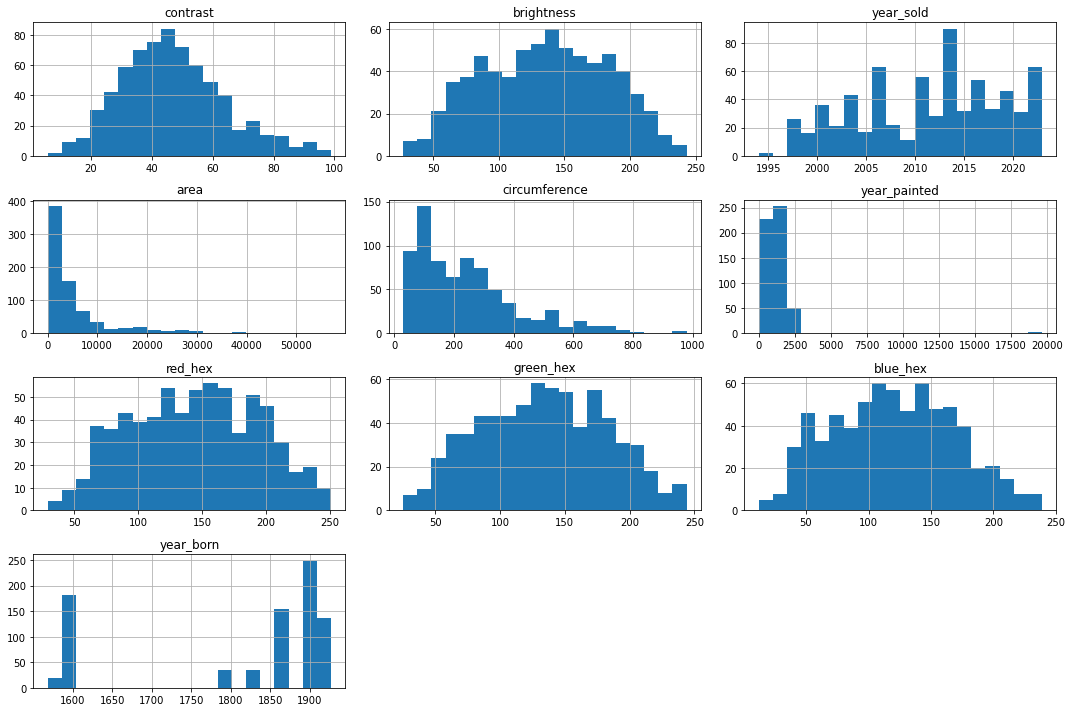

In [55]:
numerical_columns = df.select_dtypes(include=['float64','int64']).columns
numerical_columns = numerical_columns[numerical_columns != 'price_EUR']
df[numerical_columns].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

**brightness**

brightness is only the second histogram, we put it first because it's a part of contrast so than it is easier to understand.
This value ranges from 0 to 250 and the first represents complete darkness or black, all pixels are as dark as possible. An image with a brightness score of 255 has all pixels as bright or white as possible. As a consequence 127,5 represents a balanced or neutral brightness, and there's neither an overall brith nor dark bias. The brightness is normally distributed.

**contrast**

A contrast of 0 means that the entire painting has the same level o brightness and there are no discernible diffferences between light and dark areas. 100 Would suggest maximum contrast, where the brightest elemetns are at their brightest and the darkest elements are at their darkest.The transition between light and dark are sharp and abrupt.
The distribution is slightly right skewed, which means that the noticeable difference between light and dark areas is a bit under 50.

**year_sold**

A quasi linear function is apparent. 

**area** **circumference**

With a histogram like this, there is a big chance there will be outliers. Because of that, we need to double check if these outliers are due to a mistake in the data manipulation from 'details' to 'dimension' to 'length and width' to area and circumference. The chance a mistake or error happened is big due to the multiple manipulations. 

We checked the width and length who fell out of the 3times difference inter quartile. For these values we checked the dimensions manuel and they were all right. Therefore, we will not drop these!

**year_painted**

This should be a graph in between the born year of the oldest ( back in history ) and 2023. The values that are not in between these values are going to be filled in with nan and afterwards going to be valued due to born_year artist + 50 and then plus a random number of this interval[-20;20]. 

**red_hex** **green_hex** **blue_hex**

Each hex ( red, green and blue_hex ) have an intensity value ranging from 0 to 255, where 0 represents the minimum intensity (no color) and 255 represents the maximum intensity (full color).
We see for each hex that the distribution is rather normal, which relates to the results of brightness.

**year_born**

For this statistic, it is better to look at it for each artist instead of all paintings because now the artists who's frequency is higher dominate in this graph.

In [56]:
print(df.isnull().sum())

artist             0
title             52
faces            121
contrast         121
brightness       121
year_sold        121
city_auction       0
currency           0
price_EUR          0
signed             0
area              78
circumference     78
year_painted     279
medium             0
surface            0
red_hex          121
green_hex        121
blue_hex         121
year_born          0
dead               0
dtype: int64


now we need to see what we have to do for the missing values!

**for the visual features**

pos
+ the original data distribution is preserved for the imputed feature
+ no wrong assumptions about the similarity of missing values to existing categories, which is almost impossible to do with visual characteristics

neg
- may introduce bias, 
- can impact the performance of some models, they can see the 'missing' category as a meaninful feature, affecting the performance
- increased cardinaltiy -- higher cadrinaltiy can bechallenging for certain models

In [57]:
# going to put the visual characteristics to the mean of that feature for each individual artist
# numerical features --> normal distributed and no outliers --> mean
df['contrast'] = df.groupby('artist')['contrast'].transform(lambda x: x.fillna(x.mean()))
df['brightness'] = df.groupby('artist')['brightness'].transform(lambda x: x.fillna(x.mean()))
df['red_hex'] = df.groupby('artist')['red_hex'].transform(lambda x: x.fillna(x.mean()))
df['green_hex'] = df.groupby('artist')['green_hex'].transform(lambda x: x.fillna(x.mean()))
df['blue_hex'] = df.groupby('artist')['blue_hex'].transform(lambda x: x.fillna(x.mean()))

# boolean feature --> no impact on outliers, simple, intuitive, did the same for the other categories
#                     however, we will lose variability
df['faces'] = df.groupby('artist')['faces'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['faces'].mode()[0]))

#### for the other features

In [58]:
# putting 'missing' when the value of 'title' is nan
df['title'].fillna('missing', inplace=True)

for title

pro
+ preserves information about missingness
+ easy to interpret, binary nature is straightforward to interpet, and its inclusion does not introduce additional categories

cons
- increased dimensionality
- may be redundant for some models (weigerachtig), 
- may lead to interpretability challenges

In [59]:
# missing value of year_sold
frequency = df['year_sold'].value_counts()
weight_dict = dict(zip(frequency.index, frequency))
result_df = pd.DataFrame(list(weight_dict.items()), columns=['year_sold', 'frequency'])
result_df['weight'] = result_df['frequency'] / result_df['frequency'].sum()
print(result_df.head(2))

# function to fill NaN values in Year_sold based on the weight
def fill_nan_based_on_weight(row):
    if pd.isna(row['year_sold']):
        return np.random.choice(result_df['year_sold'], p=result_df['weight'])
    else:
        return row['year_sold']

df['year_sold'] = df.apply(fill_nan_based_on_weight, axis=1)
print(df['year_sold'].isna().sum())

   year_sold  frequency    weight
0       2014         52  0.075362
1       2022         41  0.059420
0


In [60]:
# area and circumference --> because skewed we do the median of each artist
df['area'] = df.groupby('artist')['area'].transform(lambda x: x.fillna(x.median()))
df['circumference'] = df.groupby('artist')['circumference'].transform(lambda x: x.fillna(x.median()))

In [61]:
# year painted --> we take a standardization of the last x years the artist lived an then random numbers
# Define a function to fill missing values

def fill_year_painted(row):
    if np.isnan(row['year_painted']):
        # Calculate the range based on 'year_born_x' + 50
        lower_bound = row['year_born'] + 50 - 20
        upper_bound = row['year_born'] + 50 + 20

        # Generate a random number in the defined range
        random_year = np.random.randint(lower_bound, upper_bound + 1)

        return random_year
    else:
        return row['year_painted']

# Apply the function to fill missing values in 'year_painted'
df['year_painted'] = df.apply(fill_year_painted, axis=1)
print(df['year_painted'].isna().sum())


0


In [62]:
print(df.isnull().sum())

artist           0
title            0
faces            0
contrast         0
brightness       0
year_sold        0
city_auction     0
currency         0
price_EUR        0
signed           0
area             0
circumference    0
year_painted     0
medium           0
surface          0
red_hex          0
green_hex        0
blue_hex         0
year_born        0
dead             0
dtype: int64


#### adding the column called 's&p500 return per year'

we add this becausee is price is slightly correlated witht the financial market.

due to the fact that their is a delay we take a delay of one year so we put for each respectively year_sold, the return of the year before.


In [63]:
# first we are going to make a dataframe with a column year and a column with the value
# making a dataframe for each year when it was sold
unique_years = sorted(df['year_sold'].unique())
return_sp500 = [0.0997,0.0133,0.2268,0.3310,0.2834,0.2089,-0.0903,-0.1185,-0.2197,0.2836,0.1074,0.0483,0.1561,0.0548,-0.3655,0.2594,0.1482,0.0210,0.1589,0.3215,0.1352,0.0138,0.1177,0.2161,-0.0423,0.3121,0.1802,0.2847,-0.1801,]

# creating df
df_sp = pd.DataFrame({
    'year' : unique_years,
    'return_sp' : return_sp500
})

df_sp.head(2)

,year,return_sp
0,1994,0.0997
1,1995,0.0133


In [64]:
merged_df = pd.merge(df, df_sp, left_on='year_sold', right_on='year', how='left')
merged_df = merged_df.drop('year', axis=1)
df = merged_df
df.head(2)

,artist,title,faces,contrast,brightness,year_sold,city_auction,currency,price_EUR,signed,...,circumference,year_painted,medium,surface,red_hex,green_hex,blue_hex,year_born,dead,return_sp
0,Pierre Alechinsky,Cache-telé (Hidden Television),True,52.600858,101.139904,2018,Amsterdam,EUR,87500.0,True,...,536.0,1973.0,missing,canvas,87.0,109.0,103.0,1927,False,0.2161
1,Theo Van Rysselberghe,Jeune dame lisant,True,49.257938,136.515970,2010,Paris,EUR,79000.0,True,...,243.6,1887.0,Oil-Based Paintings,canvas,144.0,131.0,125.0,1862,True,0.2594


#### feedback output above
All the values have been filled in, nonetheless, some visual features have still some none values but due to a boolean variable 'missing value visual characteristics' we try to let the algorithm know that these are special rows.

now we see that the only values with missing values that aren't adapted to the situation are the estimations but we don't need this for our model, only to compare the sum of residuals at the end with the sum of residuals of our algorithm.

#### distribution of the features

**target**

In [65]:
# descriptive statistics
stats = df['price_EUR'].describe()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(stats)

# gives an overall sense of the central tendency and variability of the prices

count        811.000
mean      654665.181
std      2340433.149
min           75.320
25%         4488.985
50%        23622.050
75%       195584.345
max     23596150.450
Name: price_EUR, dtype: float64


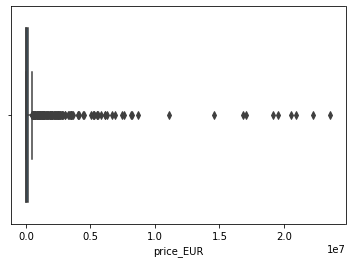

In [66]:
# boxplots
sns.boxplot(x = df['price_EUR'])
plt.show()

# outliers can be easily identified in a box plots

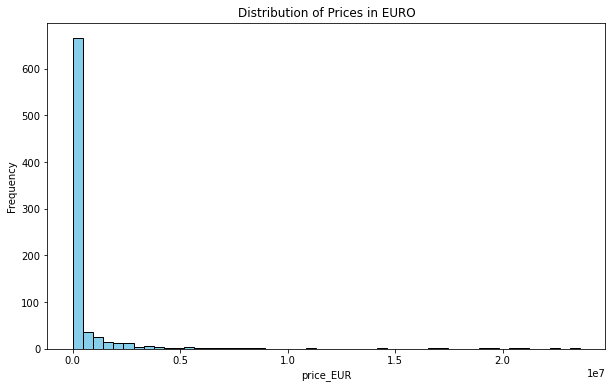

In [67]:
# histogram
plt.figure(figsize=(10, 6))
plt.hist(df['price_EUR'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Prices in EURO')
plt.xlabel('price_EUR')
plt.ylabel('Frequency')
plt.show()

# insights in shape of distribution (skewed!!!)

In [68]:
# percentiles
percentiles = np.percentile(df['price_EUR'], [25, 50, 75])
print(percentiles)

# outliers may have a significant impact on the mean, but percentiles provide a more robust measure of the spread

[  4488.985  23622.05  195584.345]


In [69]:
# outliers both sides
Q1 = df['price_EUR'].quantile(0.25)
Q3 = df['price_EUR'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
num_outliers = ((df['price_EUR'] < lower_bound) | (df['price_EUR'] > upper_bound)).sum()

print(f"The number of outliers in 'price_EUR' is: {num_outliers}")

The number of outliers in 'price_EUR' is: 146


In [70]:
# Calculate Q3
Q3 = df['price_EUR'].quantile(0.75)

# Define the upper bound for outliers (above Q3)
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers above Q3
num_outliers_above_Q3 = (df['price_EUR'] > upper_bound).sum()

print(f"The number of outliers above Q3 in 'price_EUR' is: {num_outliers_above_Q3}")

The number of outliers above Q3 in 'price_EUR' is: 146


In [71]:
# outlier detection (Z-score)
from scipy.stats import zscore
z_score = zscore(df['price_EUR'])
outliers = np.where(np.abs(z_score)>3)
print(outliers)
# help detect observation that deviate significantl from the norm

(array([  6,  15,  32,  35,  87,  88,  90,  93,  95, 100, 113, 125, 212],
      dtype=int64),)


In [72]:
# separate analysis
without_outliers = df[df['price_EUR'] < 0.9 * df['price_EUR'].max()]
# one outlier that is dropped here

Numerical features

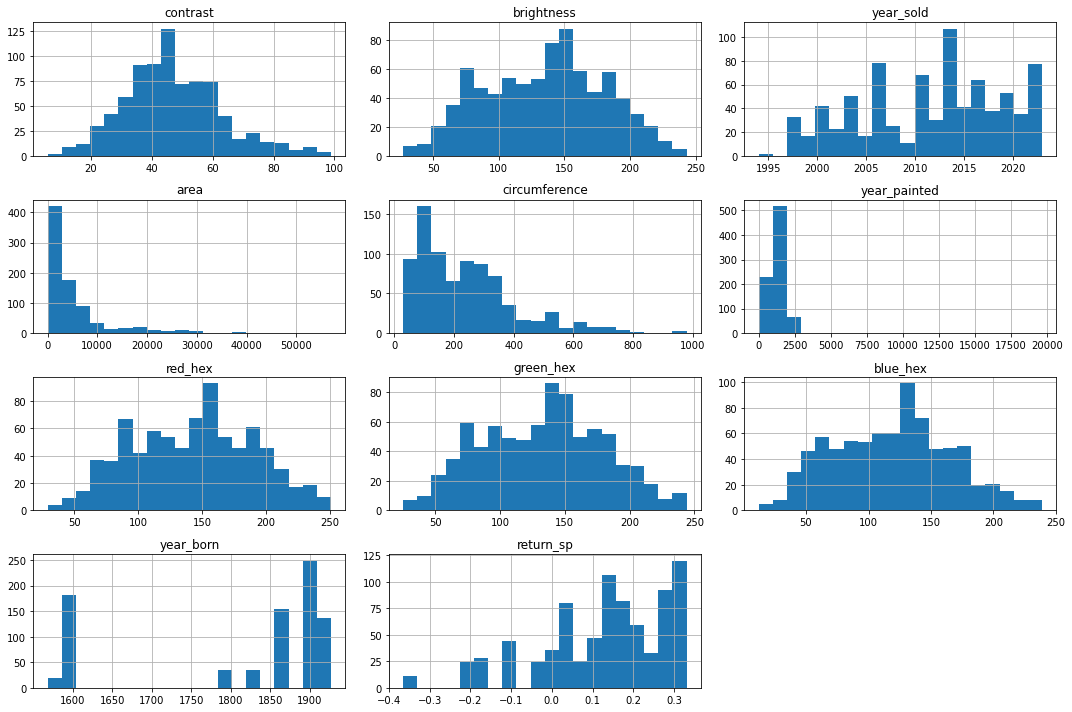

In [73]:
numerical_columns = df.select_dtypes(include=['float64','int64']).columns
numerical_columns = numerical_columns[numerical_columns != 'price_EUR']
df[numerical_columns].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

**brightness**

brightness is only the second histogram, we put it first because it's a part of contrast so than it is easier to understand.
This value ranges from 0 to 250 and the first represents complete darkness or black, all pixels are as dark as possible. An image with a brightness score of 255 has all pixels as bright or white as possible. As a consequence 127,5 represents a balanced or neutral brightness, and there's neither an overall brith nor dark bias. The brightness is normally distributed.

**contrast**

A contrast of 0 means that the entire painting has the same level o brightness and there are no discernible diffferences between light and dark areas. 100 Would suggest maximum contrast, where the brightest elemetns are at their brightest and the darkest elements are at their darkest.The transition between light and dark are sharp and abrupt.
The distribution is slightly right skewed, which means that the noticeable difference between light and dark areas is a bit under 50.

**year_sold**

A quasi linear function is apparent. 

**area** **circumference**

With a histogram like this, there is a big chance there will be outliers. Because of that, we need to double check if these outliers are due to a mistake in the data manipulation from 'details' to 'dimension' to 'length and width' to area and circumference. The chance a mistake or error happened is big due to the multiple manipulations. 

We checked the width and length who fell out of the 3times difference inter quartile. For these values we checked the dimensions manuel and they were all right. Therefore, we will not drop these!

**year_painted**

This should be a graph in between the born year of the oldest ( back in history ) and 2023. The values that are not in between these values are going to be filled in with nan and afterwards going to be valued due to born_year artist + 50 and then plus a random number of this interval[-20;20]. 

**red_hex** **green_hex** **blue_hex**

Each hex ( red, green and blue_hex ) have an intensity value ranging from 0 to 255, where 0 represents the minimum intensity (no color) and 255 represents the maximum intensity (full color).
We see for each hex that the distribution is rather normal, which relates to the results of brightness.

**year_born**

For this statistic, it is better to look at it for each artist instead of all paintings because now the artists who's frequency is higher dominate in this graph.

<AxesSubplot:>

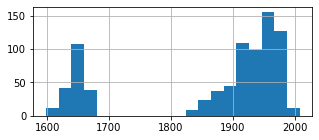

In [74]:
# looking at the unique values of year_painted becaus this needs to be in between the year of birth of the first artist and 2023.
# we are putting nan's everywhere where the year painted is outside the possible range
low_bound = min(df['year_born'].unique())
high_bound = 2023

for index, row in df.iterrows():
    if df['year_painted'][index] <= low_bound or df['year_painted'][index] > high_bound:
        df.loc[index, 'year_painted'] = np.nan
# fill in the average of that artist
df['year_painted'] = df.groupby('artist')['year_painted'].transform(lambda x: x.fillna(x.mean()))

# new histogram
df['year_painted'].hist(bins=20, figsize=(5,2))

<AxesSubplot:>

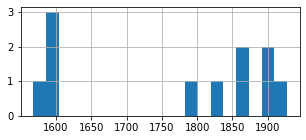

In [75]:
# new histogram to look at year_born
df_y['year_born'].hist(bins=20, figsize=(5,2))

**year_born** 

It is apparent that the paintings that are collected in this dataset are from painters that were born just before the 16th century are later than the 19th one.

# for data description

In [76]:
# the number of paintings per painter
# print frequention of the artists 
artist_freq = df['artist'].value_counts()
print(f"There are {len(artist_freq)} different artists in {len(df)} samples and the frequency of each different artist is:")
print(artist_freq)

There are 11 different artists in 811 samples and the frequency of each different artist is:
artist
Rene Magritte               158
Pierre Alechinsky           137
James Ensor                 102
Anthony Van Dyck             95
Paul Delvaux                 91
Theo Van Rysselberghe        53
Jan Breughel the younger     43
Jacob Jordaens               43
Felicien Rops                35
Eugene Verboeckhoven         34
Jan Breughel the elder       20
Name: count, dtype: int64


In [77]:
# In which year was the first painting sold in this dataset
min_year = df['year_sold'].min()
max_year = df['year_sold'].max()
print(f'The earliest painting in this dataset was sold in {min_year} and the last one in {max_year} which has {max_year-min_year} years between them.')

The earliest painting in this dataset was sold in 1994 and the last one in 2023 which has 29 years between them.


#### information of artists

In [78]:
# making a dataframe with all the important information of the artist
# Group by 'artist' and aggregate the desired statistics
df_artist = df.groupby('artist').agg({
    'artist': 'count',
    'price_EUR': ['min', 'mean', 'max', 'sum']
})

# Rename the columns for clarity
df_artist.columns = ['count', 'min', 'mean', 'max', 'total']

# Reset index to make 'artist' a regular column
df_artist.reset_index(inplace=True)

# Display the new DataFrame
df_artist.head(2)

,artist,count,min,mean,max,total
0,Anthony Van Dyck,95,194.780,165621.720,4025443.900,15734063.420
1,Eugene Verboeckhoven,34,500.000,27034.417,156000.000,919170.180


## looking which features are correlated 

In [79]:
df.dtypes

artist            object
title             object
faces               bool
contrast         float64
brightness       float64
year_sold          int64
city_auction      object
currency          object
price_EUR        float64
signed              bool
area             float64
circumference    float64
year_painted     float64
medium            object
surface           object
red_hex          float64
green_hex        float64
blue_hex         float64
year_born          int64
dead                bool
return_sp        float64
dtype: object

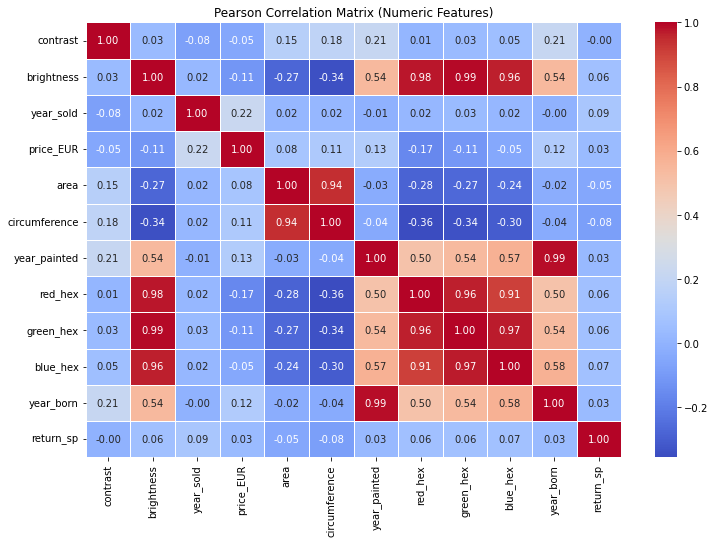

In [80]:
# correlationmatrix, Pearson correlation, only for numeric features
numeric_features = df.select_dtypes(include=['float64','int64'])

corr_matrix = numeric_features.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix (Numeric Features)')
plt.show()

**feedback**

By working with a heatmap, it is easier to see when there are highly correlated values.

There is no strict rule for what correlation coefficient consitutes "high" multicollinearity, but a commonly threshold is around 0.8 or higher. if two or more features have a corr coefficient close to +1 r -1, it indicates a high degree of correlation. In this case of multicollinearity, yyou may consider dropping one of the variables to mitigate redundancy.

Firstly, it is apparent that brightness is highly ( almost perfectly ) correlated with the different color_hex blue, green and red. Due to this reason, we shall need to drop some features. There has been chosen to keep brightness because this is one features and we can drop 3 others gives us a better dimensionality.

Secondly, there is a correlation of 0.51 of brightness and year_born. On the first look, this seems unlogical, nonetheless, the year when the artist was born influence the movement and this can be correlated with the brightness of paintings is that movement. Different aristic styles and eras may be associated with specific levels of brightness in paintings. We keep both features and see later if we will drop one. Also because this is underneath the common threshold of 0.8.

Thirdly, we observe an almost perfect positive correlation between the 'year_painted' and 'year_born' columns. This correlation is expected as, with a small deviation, the values are nearly identical. However, we choose to retain the 'year_born' column because it represents information that is 100% accurate. Additionally, we have filled in some values in the 'year_painted' column, leading to potential data leakage in this context.

"Finally, the 'area' and 'circumference' exhibit a strong positive correlation, scoring 0.94. Following univariate testing, we can determine which variable has the strongest relationship with the target feature, 'price in euros.' The variable demonstrating the most robust relationship will be retained."


In [81]:
# univariate testing, to see the relationship of all features seperately with the output
from scipy.stats import ttest_ind, f_oneway

# List of numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Perform t-test for each numeric column
for column in numeric_columns:
    statistic, p_value = ttest_ind(df[column], df['price_EUR'])
    print(f"T-test for {column}: p-value = {p_value}")
    
# List of categorical columns
categorical_columns = df.select_dtypes(include=['object','bool']).columns

# Perform ANOVA for each categorical column
for column in categorical_columns:
    groups = df.groupby(column)['price_EUR'].apply(list)
    statistic, p_value = f_oneway(*groups)
    print(f"ANOVA for {column}: p-value = {p_value}")    

T-test for contrast: p-value = 3.0777957755013894e-15
T-test for brightness: p-value = 3.1034721954045874e-15
T-test for year_sold: p-value = 3.706133136667523e-15
T-test for price_EUR: p-value = 1.0
T-test for area: p-value = 4.901436470863685e-15
T-test for circumference: p-value = 3.133551549488896e-15
T-test for year_painted: p-value = 3.655245499314833e-15
T-test for red_hex: p-value = 3.1059119617018645e-15
T-test for green_hex: p-value = 3.103078107600885e-15
T-test for blue_hex: p-value = 3.0990032406782313e-15
T-test for year_born: p-value = 3.637462564271004e-15
T-test for return_sp: p-value = 3.0641406314390914e-15
ANOVA for artist: p-value = 3.1838311844635605e-29
ANOVA for title: p-value = 0.14513140689042411
ANOVA for faces: p-value = 0.04921331077964482
ANOVA for city_auction: p-value = 1.9426780681993403e-05
ANOVA for currency: p-value = 0.0005587610396531135
ANOVA for signed: p-value = 9.754589761545304e-05
ANOVA for medium: p-value = 3.116470699146709e-08
ANOVA for su

**feedback**

p-value of 1 --> **price_EUR** --> suggests that there's no signficant difference in means between groups. 

p-value close to 0 --> **year_sold, area, circumference, year_painted, year_born, return_sp, artist, city_auction, currency, signed, medium, surface, dead, contrast, birhtness, red green and blue_hex** --> indicate that there is significant evidence to reject teh null hypothesis. This means that these features are likely to be associated with variations in the target variable or with other means are likely to be associated to influence the price of the painting.

high p-value --> **title (0.1313), faces(0.047 and 0.1869 when we did it for only the non missing values)** --> These p-values suggests that there is not enough evidence to reject the null hypothesis that the means of "price_EUR" are the same acorss different levels of the 'title' of 'face' feature.

Given that **'area' and 'circumference'** have a high correlation (0.94), it suggests that these two features are strongly correlated, meaning they provide similar information. In such cases, you might want to consider dropping one of the two features to avoid multicollinearity in your model. Multicollinearity can lead to unstable coefficient estimates ad make it challenging to interpret the individual effects of each feature. When deciding which one to drop, you could cosider factors such as the interpretability of the feature, domain knowledge, or the p-values from the T-tests. In the context of the T-tests, a lower p-value generally indicates stronger evidence against the null ypothesis. In this case, both 'area' and 'circumference' have extremely low p-values, nevertheless, the one of 'circumference' is a bit smaller so we keep that one.

In [82]:
# dropping the features that have no significant influence or are correlated with others.
df.drop(['year_painted','red_hex','green_hex','blue_hex','title','faces','area'], axis=1, inplace=True)
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,price_EUR,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


## Feature engineering
Creating good features is probably the most important step in the machine learning process. 
This might involve doing:
- transformations
- aggregating over data points or over time and space, or finding differences (for example: differences between two monthly bills, time difference between two contacts with the client) 
- creating dummy (binary) variables
- discretization

Business insight is very relevant in this process.

#### Checking if types are categorical and transforming it to numerical & transforming binary columns to integer

In [83]:
df.dtypes

artist            object
contrast         float64
brightness       float64
year_sold          int64
city_auction      object
currency          object
price_EUR        float64
signed              bool
circumference    float64
medium            object
surface           object
year_born          int64
dead                bool
return_sp        float64
dtype: object

In [84]:
# create a figure with subplots for each column
# Convert boolean columns to categorical ( help maintain consistency in the encoding process. 
# It makes the interpretation of the encoded features more straightforward)
df['signed'] = df['signed'].astype('category')
df['dead'] = df['dead'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   artist         811 non-null    object  
 1   contrast       811 non-null    float64 
 2   brightness     811 non-null    float64 
 3   year_sold      811 non-null    int64   
 4   city_auction   811 non-null    object  
 5   currency       811 non-null    object  
 6   price_EUR      811 non-null    float64 
 7   signed         811 non-null    category
 8   circumference  811 non-null    float64 
 9   medium         811 non-null    object  
 10  surface        811 non-null    object  
 11  year_born      811 non-null    int64   
 12  dead           811 non-null    category
 13  return_sp      811 non-null    float64 
dtypes: category(2), float64(5), int64(2), object(5)
memory usage: 77.9+ KB


We convert the binary categorical variables from float to integer. This will make it easier to work witht them later.

# DESCRIPTIVE MOMENT 

In [85]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,price_EUR,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [86]:
df = df[~df['city_auction'].isin(['Hong Kong','Milan'])]

In [87]:
print(f'the dataset had {df.shape[0]} features and {df.shape[1]} columns.')

the dataset had 809 features and 14 columns.


In [88]:
# Information about the samples
samples = len(df)
print(samples)
min_date = df['year_sold'].min()
max_date = df['year_sold'].max()
print(min_date)
print(max_date)

809
1994
2023


In [89]:
# Target feature
min_price = df[df['price_EUR'] > 0]['price_EUR'].min()
max_price = df['price_EUR'].max()
total = sum(df['price_EUR'])
print(total)
print(min_price)
print(max_price)
number = len(df[df['price_EUR']==0])
print(number)

524772518.60999936
75.32
23596150.45
0


In [90]:
# artist
import pandas as pd

# Assuming df is your original DataFrame
# Grouping by 'artist' and aggregating price statistics
grouped_data = df.groupby('artist')['price_EUR'].describe()

# Creating the new DataFrame
result_df = pd.DataFrame({
    'artist': grouped_data.index,
    'count': grouped_data['count'],
    'average': grouped_data['mean'],
    'std dev': grouped_data['std'],
    'min': grouped_data['min'],
    '25%': grouped_data['25%'],
    '50%': grouped_data['50%'],
    '75%': grouped_data['75%'],
    'max': grouped_data['max'],
    'total': grouped_data['count'] * grouped_data['mean']  # Total = count * average
})

# Displaying the result DataFrame
print(result_df)


                                            artist   count     average  \
artist                                                                   
Anthony Van Dyck                  Anthony Van Dyck  95.000  165621.720   
Eugene Verboeckhoven          Eugene Verboeckhoven  34.000   27034.417   
Felicien Rops                        Felicien Rops  35.000   10203.283   
Jacob Jordaens                      Jacob Jordaens  43.000  203264.717   
James Ensor                            James Ensor 102.000  111794.619   
Jan Breughel the elder      Jan Breughel the elder  20.000  470298.059   
Jan Breughel the younger  Jan Breughel the younger  43.000  195599.899   
Paul Delvaux                          Paul Delvaux  91.000  276618.521   
Pierre Alechinsky                Pierre Alechinsky 136.000   44883.927   
Rene Magritte                        Rene Magritte 157.000 2638164.809   
Theo Van Rysselberghe        Theo Van Rysselberghe  53.000  459124.620   

                             std dev 

In [91]:
# location and most money per location
import pandas as pd

# Assuming df is your original DataFrame
# Grouping by 'city_auction' and aggregating count and sum
city_stats = df.groupby('city_auction').agg({'city_auction': 'count', 'price_EUR': 'sum'})

# Renaming columns for clarity
city_stats = city_stats.rename(columns={'city_auction': 'count', 'price_EUR': 'total_spent'})
city_stats['average'] = city_stats['total_spent'] / city_stats['count']
city_stats = city_stats.sort_values(by='average', ascending=False)

# Displaying the result DataFrame
print(city_stats)

              count   total_spent     average
city_auction                                 
New York        144 159090598.830 1104795.825
London          345 316731867.800  918063.385
Paris            91  33845986.000  371933.912
unknown         125  11371555.730   90972.446
Amsterdam       104   3732510.250   35889.522


In [92]:
# we dropped the rows of 'milan' and 'hong kong' because there were only 1 row each and it was 'annoying' the code

In [93]:
# currency and most money per currency

# Assuming df is your original DataFrame
# Grouping by 'city_auction' and aggregating count and sum
currency_stats = df.groupby('currency').agg({'currency': 'count', 'price_EUR': 'sum'})

# Renaming columns for clarity
currency_stats = currency_stats.rename(columns={'currency': 'count', 'price_EUR': 'total_spent'})
currency_stats['average'] = currency_stats['total_spent'] / currency_stats['count']
currency_stats = currency_stats.sort_values(by='average', ascending=False)

# Displaying the result DataFrame
print(currency_stats)

          count   total_spent    average
currency                                
USD         169 165137381.590 977144.270
GBP         418 321968556.920 770259.706
EUR         180  37082906.000 206016.144
NLG          42    583674.100  13897.002


In [94]:
# currency and most money per currency

# Assuming df is your original DataFrame
# Grouping by 'city_auction' and aggregating count and sum
surface_stats = df.groupby('surface').agg({'surface': 'count', 'price_EUR': 'sum'})

# Renaming columns for clarity
surface_stats = surface_stats.rename(columns={'surface': 'count', 'price_EUR': 'total_spent'})
surface_stats['average'] = surface_stats['total_spent'] / surface_stats['count']
surface_stats = surface_stats.sort_values(by='average', ascending=False)

# Displaying the result DataFrame
print(surface_stats)

         count   total_spent     average
surface                                 
canvas     300 407095665.510 1356985.552
other      114  35691807.100  313086.027
paper      292  74849470.160  256333.802
missing    103   7135575.840   69277.435


In [95]:
# currency and most money per currency

# Assuming df is your original DataFrame
# Grouping by 'city_auction' and aggregating count and sum
medium_stats = df.groupby('medium').agg({'medium': 'count', 'price_EUR': 'sum'})

# Renaming columns for clarity
medium_stats = medium_stats.rename(columns={'medium': 'count', 'price_EUR': 'total_spent'})
medium_stats['average'] = medium_stats['total_spent'] / medium_stats['count']
medium_stats = medium_stats.sort_values(by='average', ascending=False)

# Displaying the result DataFrame
print(medium_stats)

                      count   total_spent     average
medium                                               
Oil-Based Paintings     410 443763371.760 1082349.687
Watercolour Art          64  60163076.320  940048.068
missing                  84   7996315.110   95194.227
Pen and Ink Drawings    251  12849755.420   51194.245


In [96]:
# currency and most money per currency

# Assuming df is your original DataFrame
# Grouping by 'city_auction' and aggregating count and sum
signed_stats = df.groupby('signed').agg({'signed': 'count', 'price_EUR': 'sum'})

# Renaming columns for clarity
signed_stats = signed_stats.rename(columns={'signed': 'count', 'price_EUR': 'total_spent'})
signed_stats['average'] = signed_stats['total_spent']/signed_stats['count']
signed_stats = signed_stats.sort_values(by='average', ascending=False)

# Displaying the result DataFrame
print(signed_stats)

        count   total_spent    average
signed                                
True      580 490829549.760 846257.844
False     229  33942968.850 148222.571


In [97]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,price_EUR,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [268]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


### Splitting the data

In [280]:
### here we are making feature called dataframe with df as dataframe to always have the standard df somewhere
dataframe = df
dataframe.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


We are working with a time series dataset because the collected datapoints are measured over a series of time intervals. Each data point is associated with a specific timestamp of time period, and the sequence of observations is ordered chronologically. 

Time series datasets are commonly used in various fields to analyze and understand trends, patterns, and behaviours over time. 

In [99]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,price_EUR,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [100]:
df = df.rename(columns={'price_EUR': 'target'})

In [101]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [269]:
#  When dealing with time series data, it's important to split the dataset in a way that respects the temporal
# order to avoid data leakage and to simulate a more realistic scenario where you train on past data and 
# evaluate on future data.

# step 1: sort your data in ascending order 'year_sold'
df = df.sort_values(by='year_sold')

# step 2: define a split point. We opt for 80%
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

# Check the time range in each set
print("Training Set Time Range:", train_set['year_sold'].min(), train_set['year_sold'].max())
print("Testing Set Time Range:", test_set['year_sold'].min(), test_set['year_sold'].max())

Training Set Time Range: 1994 2019
Testing Set Time Range: 2019 2023


In [270]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [271]:
# splitting training and test into X features and Y

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

**Pipeline including Column Transformer**

The pipeline consists of four main steps:

1) We use the OneHotEncoder transformer from the category_encoders library to convert categorical features represented as strings into numerical features. This is applied to the columns specified in the one_hot_cols list.

2) Transformers are defined for each column type. For categorical columns, TargetEncoder() from the category_encoders library is used to perform target encoding on region and state columns. This helps us to capture the relationship between the categorical feature and the target variable.

3) For continuous features, we first impute missing values using the median value of the feature and then standardize them using the StandardScaler transformer from the sklearn library. This is applied to the columns specified in the continuous_cols list. Scaling ensures that all continuous features are on the same scale, facilitating the algorithm in learning the correct weights and biases for each feature.

4) We use a feature selector to choose the best features with f_regression scoring function via SelectKBest. We set k to "all" to include all features, reducing dataset dimensionality, preventing overfitting, and retaining the most informative features. f_regression is used to select continuous features based on their correlation with the target variable.We chose the f_regression scoring function as it is a suitable method for selecting continuous features.

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import category_encoders as ce
from category_encoders import OneHotEncoder

In [272]:
# define the columns to encode and scale(min-max)
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

# Modeling

We are going to see different approaches and tune hyperparameters of each approach. Model selection and tuning using CV is on training set, avoiding data leakage. 

We perform hyperparameter tuning using grid search with cross-validation. The training data is dived into 5folds and the model is trained on 4 folds and validated on the remaining fold. This process is repeated 5 times, with each fold being the validation test once.

For testing the model we only use the training set. As the metric to estimate the model's performance on the unseen data we use the MAE (mean absolute error). It is robust to outliers, which is important with some painings being significant more expensive that others. This is for the test-sets!

This approach is used to prevent overfitting to the test set and obtain optimistic estimates of the model's preformance on unseen data during the hyperparameter tuning process. 

The test dataset will only be used as a final evaluation of the model after the hyperparameters have been tunes and the model has been trained on the entire training set.

### linear regression, Lasso and Ridge

We used Linear regression, Lasso and Ridge as our initial models for prediciting painting prices because they can handle both categorical annd continiuous features. 

**Linear Regression** serves as a simple and straightforward model thaht sets a baseline performance for painting price prediction. However, it might overfit the model if there are too many features or if the features are highly correlated.

On the other hand, **Lasso and Ridge regression**£ are regularized linear regression models that can adress overfitting by adding a penalty term to the objective function. Ridge regression can mitigate the impact of highly correlated features by shrinking their coefficients towards each other. We chose these models for painting price prediction because they can provide more stable and understandable results compared to other complex models.

In [107]:
# libraries for the models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt

In [108]:
# define the models
linear = LinearRegression()
# alpha is the regularization term, the larger the stronger the regularization. If 0 you have a linear regression
# choosing the right alpha is crucial: to small --> overfitting, to large --> shrinkage of coefficient #underfitting
ridge = Ridge(alpha=0.5)
lasso = Lasso(alpha=0.5)

# define the pipelines
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', linear)
])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', ridge)
])

pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', lasso)
])

# define the hyperparameters to search
# purpose = explore different combinations of these hyperparameters to find the 
# set that results in the best model performance. 
param_grid = [{'estimator': [Ridge()],
              'estimator__alpha': [0.01, 0.1, 1, 10, 100]
              },
              {'estimator': [Lasso()],
              'estimator__alpha': [0.01, 0.1, 1, 10, 100]
              }
]

# create gridsearchcv to perform this lookout for the best hyperparameters
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline_linear, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# git the grid search to the training data
grid_search.fit(x_train, y_train)

# evaluate each model using cross-validation
scores_linear = cross_val_score(pipeline_linear, x_train, y_train, cv=time_serie_split, scoring='r2')
scores_ridge = cross_val_score(pipeline_ridge, x_train, y_train, cv=time_serie_split, scoring='r2')
scores_lasso = cross_val_score(pipeline_lasso, x_train, y_train, cv=time_serie_split, scoring='r2')

# compute the mean squared error of each model
mse_linear = -cross_val_score(pipeline_linear, x_train, y_train, cv=time_serie_split, scoring='neg_mean_squared_error').mean()
mse_ridge = -cross_val_score(pipeline_ridge, x_train, y_train, cv=time_serie_split, scoring='neg_mean_squared_error').mean()
mse_lasso = -cross_val_score(pipeline_lasso, x_train, y_train, cv=time_serie_split, scoring='neg_mean_squared_error').mean()

# compute the root mean squared error of each model
rmse_linear = sqrt(mse_linear)
rmse_ridge = sqrt(mse_ridge)
rmse_lasso = sqrt(mse_lasso)

# Ensure the entire pipeline is fitted before predicting
grid_search.best_estimator_.fit(x_train, y_train)
pipeline_ridge.fit(x_train, y_train)
pipeline_lasso.fit(x_train, y_train)

# Compute the mean absolute error of each model
mae_linear = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
mae_ridge = mean_absolute_error(y_train, pipeline_ridge.predict(x_train))
mae_lasso = mean_absolute_error(y_train, pipeline_lasso.predict(x_train))

# printing all
# print best parameters and best score
print('Best parameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)
print('Best R2:', grid_search.best_estimator_.score(x_train, y_train))
print(' ')

# printing all for linear regression
print('All the metrics for Linear Regression.')
print("Linear Regression CV R-squared:", scores_linear.mean())
print("Linear Regression CV MSE:", mse_linear)
print("Linear Regression CV RMSE:", rmse_linear)
print("Linear Regression CV MAE:", mae_linear)
print(' ')

# printing all for Ridge regression
print('All the metrics for the Ridge Regression.')
print("Ridge Regression CV R-squared:", scores_ridge.mean())
print("Ridge Regression CV MSE:", mse_ridge)
print("Ridge Regression CV RMSE:", rmse_ridge)
print("Ridge Regression CV MAE:", mae_ridge)
print(' ')


# printing all for Lasso regression
print('All the metrics for the Lasso Regression.')
print("Lasso Regression CV R-squared:", scores_lasso.mean())
print("Lasso Regression CV MSE:", mse_lasso)
print("Lasso Regression CV RMSE:", rmse_lasso)
print("Lasso Regression CV MAE:", mae_lasso)

Best parameters: {'estimator': Lasso(), 'estimator__alpha': 0.01}
Best score: 1704557384399.0605
Best R2: 0.26463577040396113
 
All the metrics for Linear Regression.
Linear Regression CV R-squared: -2.1017343597313747e+20
Linear Regression CV MSE: 2.58498262984527e+31
Linear Regression CV RMSE: 5084272445340896.0
Linear Regression CV MAE: 505271.2283780633
 
All the metrics for the Ridge Regression.
Ridge Regression CV R-squared: 0.180099308007401
Ridge Regression CV MSE: 1705855230682.1257
Ridge Regression CV RMSE: 1306083.9294172965
Ridge Regression CV MAE: 503849.80246479233
 
All the metrics for the Lasso Regression.
Lasso Regression CV R-squared: 0.1727429932672306
Lasso Regression CV MSE: 1704570857361.9192
Lasso Regression CV RMSE: 1305592.1481695266
Lasso Regression CV MAE: 505268.2310321579


In [276]:
# define the models
linear = LinearRegression()
ridge = Ridge(alpha=0.5)
lasso = Lasso(alpha=0.5)

# define the pipelines
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', linear)
])

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', ridge)
])

pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', lasso)
])

# define the hyperparameters to search
param_grid = [{'estimator': [Ridge()],
               'estimator__alpha': [0.01, 0.1, 1, 10, 100]
               },
              {'estimator': [Lasso()],
               'estimator__alpha': [0.01, 0.1, 1, 10, 100]
               }
]

# create gridsearchcv to perform this lookout for the best hyperparameters
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline_linear, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# fit the grid search to the training data
grid_search.fit(x_train, y_train)

# evaluate each model using cross-validation
scores_linear = cross_val_score(pipeline_linear, x_train, y_train, cv=time_series_split, scoring='r2')
scores_ridge = cross_val_score(pipeline_ridge, x_train, y_train, cv=time_series_split, scoring='r2')
scores_lasso = cross_val_score(pipeline_lasso, x_train, y_train, cv=time_series_split, scoring='r2')

# Ensure the entire pipeline is fitted before predicting
grid_search.best_estimator_.fit(x_train, y_train)
pipeline_ridge.fit(x_train, y_train)
pipeline_lasso.fit(x_train, y_train)

# compute the R-squared of the training set for each model
r2_linear_train = grid_search.best_estimator_.score(x_train, y_train)
r2_ridge_train = pipeline_ridge.score(x_train, y_train)
r2_lasso_train = pipeline_lasso.score(x_train, y_train)

# compute the mean squared error of each model on the training set
mse_linear_train = mean_squared_error(y_train, grid_search.best_estimator_.predict(x_train))
mse_ridge_train = mean_squared_error(y_train, pipeline_ridge.predict(x_train))
mse_lasso_train = mean_squared_error(y_train, pipeline_lasso.predict(x_train))

# compute the root mean squared error of each model on the training set
rmse_linear_train = sqrt(mse_linear_train)
rmse_ridge_train = sqrt(mse_ridge_train)
rmse_lasso_train = sqrt(mse_lasso_train)

# compute the mean absolute error of each model on the training set
mae_linear_train = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
mae_ridge_train = mean_absolute_error(y_train, pipeline_ridge.predict(x_train))
mae_lasso_train = mean_absolute_error(y_train, pipeline_lasso.predict(x_train))

# print all metrics
# print best parameters and best score
print('Best parameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)
print('Best R2 (Training):', r2_linear_train)
print(' ')

# printing all for linear regression
print('All the metrics for Linear Regression.')
print("Linear Regression CV R-squared:", scores_linear.mean())
print("Linear Regression Training R-squared:", r2_linear_train)
print("Linear Regression Training MSE:", mse_linear_train)
print("Linear Regression Training RMSE:", rmse_linear_train)
print("Linear Regression Training MAE:", mae_linear_train)
print(' ')

# printing all for Ridge regression
print('All the metrics for Ridge Regression.')
print("Ridge Regression CV R-squared:", scores_ridge.mean())
print("Ridge Regression Training R-squared:", r2_ridge_train)
print("Ridge Regression Training MSE:", mse_ridge_train)
print("Ridge Regression Training RMSE:", rmse_ridge_train)
print("Ridge Regression Training MAE:", mae_ridge_train)
print(' ')

# printing all for Lasso regression
print('All the metrics for Lasso Regression.')
print("Lasso Regression CV R-squared:", scores_lasso.mean())
print("Lasso Regression Training R-squared:", r2_lasso_train)
print("Lasso Regression Training MSE:", mse_lasso_train)
print("Lasso Regression Training RMSE:", rmse_lasso_train)
print("Lasso Regression Training MAE:", mae_lasso_train)


Best parameters: {'estimator': Lasso(), 'estimator__alpha': 0.01}
Best score: 1709567759450.6094
Best R2 (Training): 0.26675893629098857
 
All the metrics for Linear Regression.
Linear Regression CV R-squared: 0.12968707305585828
Linear Regression Training R-squared: 0.26675893629098857
Linear Regression Training MSE: 1345395162329.8088
Linear Regression Training RMSE: 1159911.7045403968
Linear Regression Training MAE: 506517.2233652305
 
All the metrics for Ridge Regression.
Ridge Regression CV R-squared: 0.14266254894410454
Ridge Regression Training R-squared: 0.26673267575032367
Ridge Regression Training MSE: 1345443346762.0774
Ridge Regression Training RMSE: 1159932.4750872687
Ridge Regression Training MAE: 505076.05398940766
 
All the metrics for Lasso Regression.
Lasso Regression CV R-squared: 0.13168776078497788
Lasso Regression Training R-squared: 0.2667589361369228
Lasso Regression Training MSE: 1345395162612.4978
Lasso Regression Training RMSE: 1159911.7046622548
Lasso Regres

### feedback

* R-squared: measure that explains the variance in the target variable.
* MSE(Mean Squared Error): average squared difference between predicted and actual values.
* RMSE(Root Mean Squared Error): the square root of MSE, providing a more interpretable scale.
* MAE (Mean Absolute Error): measure the average absolute differences between the predicted values and the acutal values. It gives an equal weight to all errors, regardless of their magnitude and it is easy to interpret ( if the MAE is 10 000, the model is on average off by 10 000 units)

**Linear Regression metrics**

* R-squared: A negative value indicates that the model performs poorly and does not capture the variance
* MSE: a high MSE suggests that the predictions are far from the actual values
* RSME: An extremely high RMSE indicates significant erros in prediction
* MAE: The model is by average 471 055 euros off the price.

**Ridge Regression metrics**

* Metrics are better than those for linear regression but still not satisfactory. The regularization that mitigates the overfitting may not be sufficient for your data.
* MAE: The model is by average 469 418 euros off the price.

**Lasso Regression metrics**

* Similar to Ridge regression, it introduces L1 regularization. The metrics are comparable, indicating that both Ridge and Lasso may not be the best models for your data.
* MAE: The model is by average 471 502 euros off the price.

It might be beneficial to explore more complex models, consider additional feature engineering, or investigate if outliers or non-linear patterns are influencing the performance.

**Best Model yet**

All the metrics are better for the Ridge Regression. The model has a higher R^2 and lower RMSE and MAE, which makes is straightforward to chose the ridge regression as best model yet.

### Decision Tree

We chose the decision tree algorithm for predicting the painting prices due to several reasons. Firstly, decision trees are easy to understand and interpret, providing transparent results tha can be visualized. Secondly, decisop, trees can handle both categorical annd numerical features, making them versatile for various types of datasets. Thirdly, decision trees can capture non-linera relationships between features, allowing them to detect complex patterns that other models may miss.

In [109]:
# import libraries for the decision tree model
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [110]:
# define the final estimator
print('Decision Tree')
estimator = DecisionTreeRegressor(random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparameters to search
param_grid = {
    'estimator__max_depth': [None,1, 2,3, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# define the grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# fit the pipeline to the data using cross-validation
grid_search.fit(x_train, y_train)

# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_

# Get cross-validated R-squared scores
cv_r2_scores = cross_val_score(best_estimator, x_train, y_train, cv=time_series_split, scoring='r2')

# Print the R-squared scores for each fold
print("CV R-squared scores for each fold:", cv_r2_scores)
print("Average CV R-squared:", cv_r2_scores.mean())
print('\n')

# Predict on the entire training set
y_train_pred = best_estimator.predict(x_train)

# print the R-squared score of the model using cross-validation
r2 = grid_search.best_estimator_.score(x_train, y_train)
print("CV R-squared:", r2)

# print the mean squared error of the model using cross-validation
mse = -grid_search.best_score_
print("CV MSE:", mse)

# print the root mean squared error of the model using cross-validation
rmse = sqrt(mse)
print("CV RMSE:", rmse)
print(' ')

# Print the Mean Absolute Error (MAE) of the model using cross-validation
mae = mean_absolute_error(y_train, y_train_pred)
print("CV MAE:", mae)
print(' ')

# Print the R-squared score on the entire training set
r2_train = r2_score(y_train, y_train_pred)
print("Training Set R-squared:", r2_train)

# Print the mean squared error on the entire training set
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Set MSE:", mse_train)

# Print the root mean squared error on the entire training set
rmse_train = sqrt(mse_train)
print("Training Set RMSE:", rmse_train)
print(' ')

# Print the Mean Absolute Error (MAE) on the entire training set
mae_train = mean_absolute_error(y_train, y_train_pred)
print("Training Set MAE:", mae_train)
print(' ')

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print(' ')
print("Best MSE:", mse)

Decision Tree
CV R-squared scores for each fold: [-0.51781306  0.07703509  0.52211062  0.35444326  0.32780089]
Average CV R-squared: 0.15271536004063097


CV R-squared: 0.47846681951336356
CV MSE: 1394795576367.9175
CV RMSE: 1181014.6385070414
 
CV MAE: 308510.45348964474
 
Training Set R-squared: 0.47846681951336356
Training Set MSE: 953985486667.0203
Training Set RMSE: 976721.8061797434
 
Training Set MAE: 308510.45348964474
 
Best hyperparameters: {'estimator__max_depth': 5, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2}
 
Best MSE: 1394795576367.9175


In [278]:
# Define the final estimator
print('Decision Tree')
estimator = DecisionTreeRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the grid of hyperparameters to search
param_grid = {
    'estimator__max_depth': [None, 1, 2, 3, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# Define the grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the pipeline to the data using cross-validation
grid_search.fit(x_train, y_train)

# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_

# Get cross-validated R-squared scores
cv_r2_scores = cross_val_score(best_estimator, x_train, y_train, cv=time_series_split, scoring='r2')

# Print the R-squared scores for each fold
print("CV R-squared scores for each fold:", cv_r2_scores)
print("Average CV R-squared:", cv_r2_scores.mean())
print('\n')

# Predict on the entire training set
y_train_pred = best_estimator.predict(x_train)

# Print the R-squared score of the model using cross-validation
r2 = grid_search.best_estimator_.score(x_train, y_train)
print("CV R-squared:", r2)

# Print the mean squared error of the model using cross-validation
mse = -grid_search.best_score_
print("CV MSE:", mse)

# Print the root mean squared error of the model using cross-validation
rmse = sqrt(mse)
print("CV RMSE:", rmse)
print(' ')

# Print the Mean Absolute Error (MAE) of the model using cross-validation
mae = mean_absolute_error(y_train, y_train_pred)
print("CV MAE:", mae)
print(' ')

# Print the R-squared score on the entire training set
r2_train = r2_score(y_train, y_train_pred)
print("Training Set R-squared:", r2_train)

# Print the mean squared error on the entire training set
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Set MSE:", mse_train)

# Print the root mean squared error on the entire training set
rmse_train = sqrt(mse_train)
print("Training Set RMSE:", rmse_train)
print(' ')

# Print the Mean Absolute Error (MAE) on the entire training set
mae_train = mean_absolute_error(y_train, y_train_pred)
print("Training Set MAE:", mae_train)
print(' ')

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print(' ')
print("Best MSE:", mse)

Decision Tree
CV R-squared scores for each fold: [0.09366361 0.10750847 0.3902861  0.28446785 0.40171543]
Average CV R-squared: 0.255528292549266


CV R-squared: 0.7424535908382275
CV MSE: 1330385932501.1755
CV RMSE: 1153423.5702902796
 
CV MAE: 198515.1123647668
 
Training Set R-squared: 0.7424535908382275
Training Set MSE: 472561767352.37024
Training Set RMSE: 687431.281912869
 
Training Set MAE: 198515.1123647668
 
Best hyperparameters: {'estimator__max_depth': 10, 'estimator__max_features': 'log2', 'estimator__min_samples_leaf': 2}
 
Best MSE: 1330385932501.1755


#### feedback

* CV R-squared: A cross validation of 1 suggests that your model perfectly predicts the target variable in the training data. This is an ideal scenario, nonetheless, it could also indicate potential overfitting, expecially if the model does not generalize well to new, unseen data
* CV MSE: The lower the MSE, the better but the absolute value itself might not give a clear sense of the scale of the errors.
* CV RMSE: Lower RMSE values indicate better model performance
* MAE: The model is by average 0 euros off the price. This was also possible to see due to the R^2 which is 1 and leads to a model that perfectly predicts the price of paintings.

It is important to note that while achieving a perfect R-squared on the training data is desirable, it doesn't guarantee good generalization to new, unseen data. 

**compare with previous models**

Based on the R-squared and the RMSE, the decision tree model appears to perform better than the linear regression, ridge regression and lasso regression models. The decision tree has the highest (perfect) R-squared score of 1.0, indicating that it explains the variance perfectly ( no variance in this model which indicates overfitting ). Additionally, the decision tree has the lowest RMSE of 1325551.67, indicating that it has the smallest prediction error compared to the other models. Therefore, the decision tree model is the best choice for this particular problem yet.

### Ensemble Random Forest

As the decision tree showed promising results, we decided to utilize random forest as an ensemble method. Random forest combines multiple decision trees to improve accuracy and reduce overfitting. This is particularly important in house price prediction, where multiple variables can impact the outcome.

Random forest is also robust to outliers, which is beneficial for extreme values. Therefore, random forest is a suitable model for predicting house prices.

In [111]:
# import libraries for the RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

In [112]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
print('Random Forest')
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Random Forest
Best hyperparameters: {'estimator__max_depth': 20, 'estimator__n_estimators': 10}
Best MSE: 1312979623976.3843
Cross-validation scores: [-0.71164834  0.10401672  0.47177239  0.50534785  0.37102203]
Mean CV R-squared: 0.14810213294329871
Train R-squared: 0.8569292553428316
Train MSE: 261704181203.2496
Train RMSE: 511570.30914943607
Train MAE: 126221.72010189369


#### feedback

* The set of hyperparameters that resulted in the best performance during the grid search for a random forest regressor are a maximum depth of 10 and 25 estimators were found to be optimal.
* The mean squared error associated with these set of hyperparameters is 129714157794 and this is done on the validation set ( or a portion of the training set not used during the training ) when using the optimal hyperparameters.
* The cross validation score corresponds to a different fold in the cross-validation process and represents the R-squared scores during cross-validation. and the Mean CV R-squared value is 0.317975.
* The Train R-squared score on the training data, indicating how well them odel fiets the data it was trained on is equal to 0.87026 which is actually a good score but can indicate overfitting especially if you are comparing it with the mean CV R-squared score.
    * A significant difference between the CV R-squared score and the training R-squared score can provide insights into the model's generalization performance. 
        * If the training R-squared is much higher, it suggest that the model might be overfitting the training data. Overfitting occurs when the model learns the training data too well, capturing noise or patterns specific to the training set but not generalizable to new data. This noise can be due to outliers in the price setting of      
* The training MSE is bigger than the best scored MSE. 
    * If the difference between the training MSE and the best MSE of the validation sets is large, it can suggest several pontential issues in your ML model.
        * overfitting, the model may perform poorly on unseen data, leading to a higher MSE on the validation set. 
        * The model can be overly complex, it might fit the training data colsely but struggle to generalize to new data. comples models can be sensitive to noise in the training set, resulting in a  large difference between training and validation MSE.
        * a non representative validation set. IF the validation set is small or not representative of the overall data disttribution, the model may not generalize well.
* MAE: The model is by average 140 626 euros off the price/target feature. 
        
**what can be done to tackle these issues**

* use regularization techniques to control model complexity 
* use extra parameters for optimalization
* limiting the number of features used in the model
* drop some outliers ( because they are a reason of the problem due to noise )

**compared with previous best model**


The decision tree appears to have an issue with overfitting, as evidenced by the perfect CV R-squared and the high CV MSE. The random forest, with its ensemble approach, seem to generalize better, as indicated by a lower mean CV MSE and a more reasonable CV R-squared. Based on the provided metrics, the random forest model apperas to be performing better than the decision tree. Therefore, the ensemble random forest model is the best choice for this particular problem yet.

### gradient boosting regressor

We choose Graient Boosting because it builds an ensemble of decision trees, just like Random Forest, but instead of building tree independently, it builds them sequentially with each new tree correcting the errors of the previous ones. This can lead to a highly accurate model with lower bias and variance compared to single decision trees.

Furthermore, Gradient Boosting allows for fine-tunning of the model through the adjustment of hyperparameters, such as the learning rate, the maxium depth of trees and the number of estimators which can improve the accuracy of the model.

In [113]:
# import libraries for the Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

In [114]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [1,3,5 ,7, 10],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting
Best Hyperparameters: {'estimator__max_depth': 7, 'estimator__max_features': 'log2', 'estimator__n_estimators': 100}
Best MSE: 1333583060958.7234
Cross-validation scores: [0.32141679 0.11102071 0.43439693 0.58484352 0.33174577]
Mean CV R-squared: 0.3566847432558292
training MAE: 20904.664768030565
Train R-squared: 0.9991183799408444
Training MSE: 1612654328.923325
Training RMSE: 40157.867584364154


#### feedback

* The set of hyperparameters that resulted in the best performance during the grid search for a random forest regressor are a maximum depth of 7, max features of log(2) and 100 estimators were found to be optimal. The very high training R-squared (0.9987) suggests that the model is fitting the training data extremely well, but there is a pontential risk of overfitting.
* The mean squared error associated with these set of hyperparameters is 1244422502814 and this is done on the validation set ( or a portion of the training set not used during the training ) when using the optimal hyperparameters.
* The cross validation score corresponds to a different fold in the cross-validation process and represents the R-squared scores during cross-validation. and the Mean CV R-squared value is 0.33607.
* The Train R-squared score on the training data, indicating how well them odel fiets the data it was trained on is equal to 0.99872 which is actually almost a perfect score, nonetheless, it indicates overfitting especially if you are comparing it with the mean CV R-squared score.
    * big difference between mean cv R-squared score and training R-squared score explanation ( random forrest )
* The training RMSE is the smallest one which indicates a good model.
* The training MSE is bigger than the best scored MSE. 
    * If the difference between the training MSE and the best MSE of the validation sets is large, it can suggest several pontential issues in your ML model. (same explanation random forrest )
* MAE: The model is by average 23 510 euros off the price/target feature. 
    


While the model shows excellent perfomrance on the training data, it's imporant to evaluate its peformance on independent datasets to ensure it doesn't overfit and can generalize well to new observations. 

**compared with previous best model**

**Random Forrest Vs Gradient Boosting**

* **Mean CV R-squared**
    * Gradient boosting has a slightly hihger mean cross-validation R^2 compared to Random Forrest. A higher R^2 suggests better predicitive performance on average across different corss-validation folds.
* **Train R-squared**
    * Gradient bossting has an exceptionally high training R^2 (almost 1), indicating an almost perfect fit to the training set, raising concerns about potential overfitting.
* **Training RMSE**
    * Random Forest has a higher training RMSE compared to Gradient Boosting. A lower RMSE indicates better model performance. However, be cautious about overfitting, expecially when the training R^2 is very high.
* **Training MAE**
    * Gradient Boosting has a lower MAE (23510) compared to Random Forest (140626), which is prefered to be as small as possible.
* **Generalization**
    * Both models show improvement over the baseline (as indicated by positive cross-validation scores), but Gradient Boosting seems to generalize slightly better in terms of mean cross-validation R^2.
    
**Conclusion**
* If you prioritize generalization to new, unseen data, the Gradient Boosting model might be preferred due to its higher mean cross-validation R^2.

* If computational efficiency is a concern, and you are satisfied with the Random Forest's performance, it could be a pragmatic choice.

* Both models seem to fit the training well, but Gradient Boosting outperforms Random Forest in terms the MAE, which is know for its resiliency to outliers.

* Keep in mind that these are just a few metrics, and the final decision should consider your specific requirements, the nature of your data, and the implications of potential overfitting. You might also want to explore further tuning or consider ensemble methods combining the strengths of both models.

* Not unimportant is that Gradient Boosting is robust to outliers.

In [115]:
# import of the libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

In [116]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=200, max_depth=7,random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('Random Forest')
print('')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Random Forest

Test MSE: 10791817474913.41
Test RMSE: 3285090.1775923003
Test R-squared: 0.4107415883265494
Adjusted R2 is 0.35898240351739497
Test MAE: 1486125.4065651512


In [117]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=10, max_features= 'log2',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('Gradient Boosting')
print('')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Gradient Boosting

Test MSE: 12405623220762.424
Test RMSE: 3522161.725526303
Test R-squared: 0.32262402955954406
Adjusted R2 is 0.26312478891274727
Test MAE: 1519766.1507016283


### Feedback

**conclusion**

* The model's performance, as indicated by metrics such as Test MSE, Test RMSE, Test R-squared, and Test MAE, seems to be suboptimal. The relatively high values for MSE and RMSE, as well as the moderate R-squared and large MAE, suggest that the model might not be capturing the underlying patterns in the data effectively.

**Recommendations for improvement**

* Explore the possibility of creating new features, transofrming existing ones or dropping features to provide more meaningfull information to the model. Feature engineering can sometimes significantly improve model performance.
* Investigate and handle outliers: Outliers in the data can adversely affect the model's performance. Identify and ocnsider appropiate strategies for handling outliers in your dataset.
*

# doing the same for a dataset without outliers

In [118]:
# reindex
df = df.reset_index(drop=True)

In [119]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


##### 1. identify and understand outliers

Alright, we are going to see to different distributions of the target variable when dropping outliers.

Afterwards, we will run different models on these dataframes and look what changes in the performance.

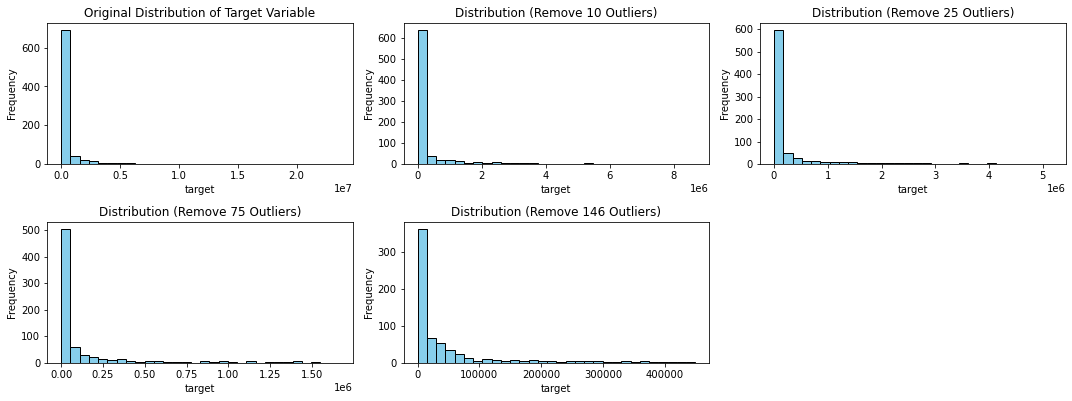

In [120]:
# Define the number of outliers to drop for each scenario
outlier_counts = [10, 25, 75, 146]

# Visual inspection for different outlier removal scenarios
plt.figure(figsize=(15, 8))

# Before outlier removal
plt.subplot(3, 3, 1)
plt.hist(df['target'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Original Distribution of Target Variable')
plt.xlabel('target')
plt.ylabel('Frequency')

# Iterate through different outlier removal scenarios
for i, outlier_count in enumerate(outlier_counts):
    # Remove the top outliers based on the specified count
    target_without_outliers = df['target'].sort_values().iloc[:-outlier_count]
    
    # Visualize the distribution after outlier removal
    plt.subplot(3, 3, i + 2)
    plt.hist(target_without_outliers, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution (Remove {outlier_count} Outliers)')
    plt.xlabel('target')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 10 biggest outliers of set dropping out of the training only

In [121]:
top_values_indices = df['target'].nlargest(10).index

In [122]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [123]:
## splitsing in 80% and then you are going to look at the indexes of the outliers --> later we are going to drop the outliers but only out of the training set
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

train_set = df[:split_point]
test_set = df[split_point:]

range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index <= range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']


In [124]:
# define the columns to encode and scale(min-max)
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [125]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
print('Random Forst')
print('')

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Random Forst

Best hyperparameters: {'estimator__max_depth': None, 'estimator__n_estimators': 100}
Best MSE: 537643176903.85
Cross-validation scores: [-0.34839672  0.11243334  0.52832668  0.58067014  0.36830978]
Mean CV R-squared: 0.24826864434244852
Train R-squared: 0.9288443066587951
Train MSE: 59896518850.66587
Train RMSE: 244737.65311178798
Train MAE: 96480.97201271313


In [126]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')
print('')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__max_features': 'log2', 'estimator__n_estimators': 200}
Best MSE: 539738704162.9201
Cross-validation scores: [0.31295054 0.13051063 0.35691415 0.63378066 0.4423248 ]
Mean CV R-squared: 0.3752961585027528
training MAE: 0.00032373148818633636
Train R-squared: 1.0
Training MSE: 4.1925530563418296e-07
Training RMSE: 0.0006474992707595762


## test

In [127]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 13251261671404.254
Test RMSE: 3640228.244410542
Test R-squared: 0.27645019726173625
Adjusted R2 is 0.21289514702121315
Test MAE: 1999268.133930006


In [128]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=7, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 12965912822988.672
Test RMSE: 3600821.131768235
Test R-squared: 0.2920309101102515
Adjusted R2 is 0.22984443599831406
Test MAE: 1952348.2622706606


##  25 biggest outliers of set dropping out of the training only

In [129]:
top_values_indices = df['target'].nlargest(25).index

In [130]:
## splitsing in 80% and then you are going to look at the indexes of the outliers --> later we are going to drop the outliers but only out of the training set
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

train_set = df[:split_point]
test_set = df[split_point:]

range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index <= range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']


# define the columns to encode and scale(min-max)
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [131]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
print('Random Forest')
print('')

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Random Forest

Best hyperparameters: {'estimator__max_depth': 30, 'estimator__n_estimators': 200}
Best MSE: 284199234267.597
Cross-validation scores: [-0.36273885  0.21738978  0.15806762  0.36478531  0.15380625]
Mean CV R-squared: 0.10626202211175968
Train R-squared: 0.9017325925708932
Train MSE: 33030613999.634483
Train RMSE: 181743.26397320614
Train MAE: 76534.52766084037


In [132]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')
print('')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting

Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__max_features': 'log2', 'estimator__n_estimators': 50}
Best MSE: 250016806748.61743
Cross-validation scores: [0.3715299  0.2854667  0.22577799 0.38637331 0.21590233]
Mean CV R-squared: 0.2970100473074126
training MAE: 7144.794955086738
Train R-squared: 0.9994154965215121
Training MSE: 196469096.7685143
Training RMSE: 14016.743443771606


## test

In [133]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 17077662860761.107
Test RMSE: 4132512.8990435237
Test R-squared: 0.06751976524626035
Adjusted R2 is -0.014387282401027601
Test MAE: 1603773.0835302467


In [134]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=20, max_features= 'log2',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 18028854404255.11
Test RMSE: 4246039.849583976
Test R-squared: 0.015582487821079294
Adjusted R2 is -0.07088661797842044
Test MAE: 1619647.7671426479


##  75 biggest outliers of set dropping out of the training only

In [135]:
top_values_indices = df['target'].nlargest(75).index
## splitsing in 80% and then you are going to look at the indexes of the outliers --> later we are going to drop the outliers but only out of the training set
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

train_set = df[:split_point]
test_set = df[split_point:]

range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index < range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']


# define the columns to encode and scale(min-max)
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [136]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
print('Random Forest')
print('')

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Random Forest

Best hyperparameters: {'estimator__max_depth': 15, 'estimator__n_estimators': 100}
Best MSE: 52191698219.15645
Cross-validation scores: [0.25589651 0.31566848 0.35166    0.48157188 0.354502  ]
Mean CV R-squared: 0.3518597744975098
Train R-squared: 0.9288684851246327
Train MSE: 5990911085.615955
Train RMSE: 77400.97599911745
Train MAE: 38762.76887664405


In [137]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')
print('')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting

Best Hyperparameters: {'estimator__max_depth': 7, 'estimator__max_features': 'log2', 'estimator__n_estimators': 100}
Best MSE: 49930627963.83559
Cross-validation scores: [0.34115123 0.43966748 0.3578388  0.49102457 0.32771277]
Mean CV R-squared: 0.39147897088328965
training MAE: 9325.554865309192
Train R-squared: 0.9972196428287093
Training MSE: 234170080.99211988
Training RMSE: 15302.616802106751


## test

In [138]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 19414079264495.656
Test RMSE: 4406141.085405193
Test R-squared: -0.06005402130756221
Adjusted R2 is -0.1531668745305237
Test MAE: 1646144.0353834857


In [139]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=50, max_depth=20, max_features= 'log2',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 19617774292297.965
Test RMSE: 4429195.671033056
Test R-squared: -0.07117624505046605
Adjusted R2 is -0.16526605035895292
Test MAE: 1630806.8123636812


## 146 biggest outliers of set dropping out of the training only

In [140]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [141]:
top_values_indices = df['target'].nlargest(146).index

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   artist         809 non-null    object  
 1   contrast       809 non-null    float64 
 2   brightness     809 non-null    float64 
 3   year_sold      809 non-null    int64   
 4   city_auction   809 non-null    object  
 5   currency       809 non-null    object  
 6   target         809 non-null    float64 
 7   signed         809 non-null    category
 8   circumference  809 non-null    float64 
 9   medium         809 non-null    object  
 10  surface        809 non-null    object  
 11  year_born      809 non-null    int64   
 12  dead           809 non-null    category
 13  return_sp      809 non-null    float64 
dtypes: category(2), float64(5), int64(2), object(5)
memory usage: 77.7+ KB


In [143]:
## splitsing in 80% and then you are going to look at the indexes of the outliers --> later we are going to drop the outliers but only out of the training set
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

train_set = df[:split_point]
test_set = df[split_point:]

range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index < range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

In [144]:
# define the columns to encode and scale(min-max)
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [145]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Best hyperparameters: {'estimator__max_depth': 15, 'estimator__n_estimators': 200}
Best MSE: 5580775573.4155245
Cross-validation scores: [0.00513161 0.14058398 0.20803055 0.31804429 0.35717368]
Mean CV R-squared: 0.2057928192875381
Train R-squared: 0.9077085867837241
Train MSE: 647449870.8368822
Train RMSE: 25445.036271086003
Train MAE: 14513.494467642173


In [146]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Best Hyperparameters: {'estimator__max_depth': 7, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 50}
Best MSE: 5173978968.048487
Cross-validation scores: [0.0232486  0.19824775 0.35358996 0.33317138 0.41144309]
Mean CV R-squared: 0.2639401581021722
training MAE: 8775.14169667045
Train R-squared: 0.9684955091143105
Training MSE: 221012744.7818106
Training RMSE: 14866.497394538184


## test

In [147]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 20729596029368.438
Test RMSE: 4552976.611994447
Test R-squared: -0.1318843057986323
Adjusted R2 is -0.2313065759025663
Test MAE: 1708753.2941561495


In [148]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=10, max_features= 'log2',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 20820597855707.723
Test RMSE: 4562959.330928529
Test R-squared: -0.13685321782598292
Adjusted R2 is -0.23671194641880566
Test MAE: 1709708.3450779587


# Model with less features

we are going to make a temporary dataframe to always come back on this dataframe

In [149]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [150]:
# we are going to drop one of the two columns --> city_auciton or currency due to high correlation
# usd --> new york // # euro --> amsterdarm or london // gbp --> london // NLZ --> dutch guilder and actually the euro but before the euro (convert to euro?)
# we chose to drop city_auction because here are missing values !!
df = df.drop('city_auction', axis=1)

In [151]:
df.head(2)

,artist,contrast,brightness,year_sold,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [152]:
# splitting the training set into features X and target variable Y
x_values = df.drop(columns=['target'])
y_values = df['target']

## 10

#### Random Forrest

In [153]:
one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

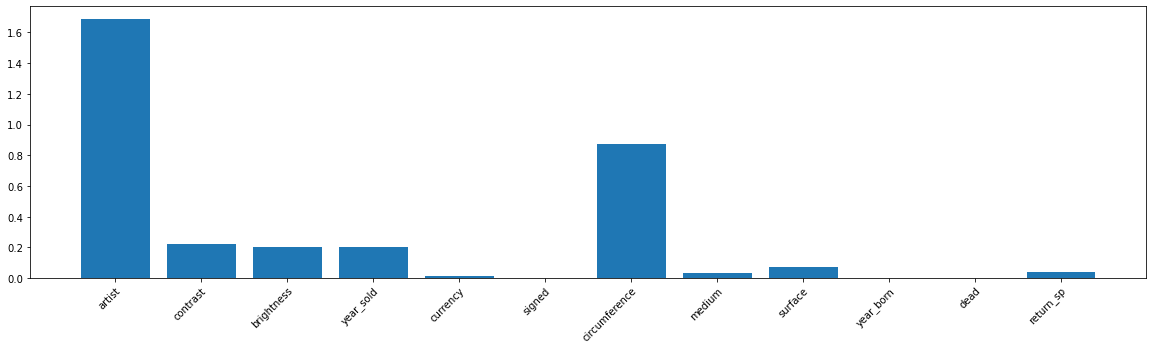

In [154]:
from sklearn.inspection import permutation_importance

estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_values, y_values)

perm_pipe = permutation_importance(pipeline, x_values, y_values, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_values.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

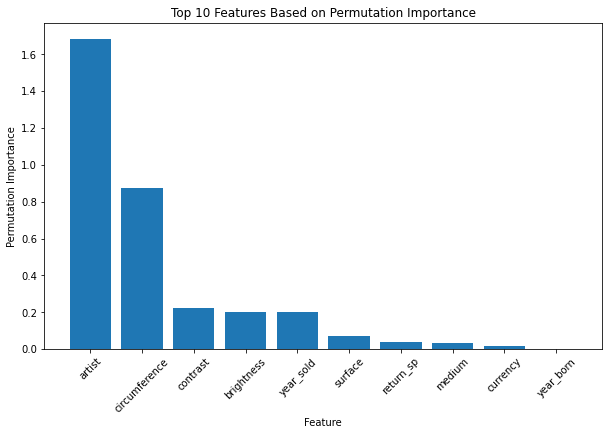

In [155]:
# Get the indices of the top 8 features
top_feature_indices_perm = feat_import_perm.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]

# Plotting the permutation importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names_perm)), feat_import_perm[top_feature_indices_perm], align="center")
plt.xticks(range(len(top_feature_names_perm)), top_feature_names_perm, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Top 10 Features Based on Permutation Importance")
plt.show()

In [156]:
# step 2: define a split point. We opt for 80%
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

x_test = test_set[top_feature_names_perm]
y_test = test_set['target']

one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'contrast', 'brightness', 'year_sold',
       'surface', 'return_sp', 'medium', 'currency', 'year_born'],
      dtype='object')


In [157]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Best hyperparameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 10}
Best MSE: 1340115713455.3887
Cross-validation scores: [-0.19161707  0.09165377  0.42177579  0.50170218  0.35524329]
Mean CV R-squared: 0.235751590859706
Train R-squared: 0.8585319134102684
Train MSE: 258772608306.9713
Train RMSE: 508696.9710023555
Train MAE: 136758.58666204358


## Test 

In [158]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 11038621020529.053
Test RMSE: 3322442.026661873
Test R-squared: 0.3972655389379346
Adjusted R2 is 0.3573493494636256
Test MAE: 1417378.706057924


#### Gradient Boosting

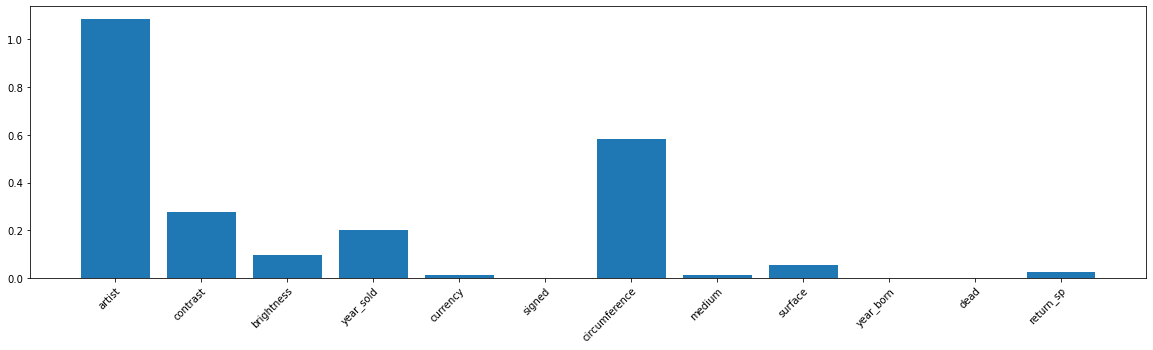

In [159]:
from sklearn.inspection import permutation_importance

estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_values, y_values)

perm_pipe = permutation_importance(pipeline, x_values, y_values, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_values.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

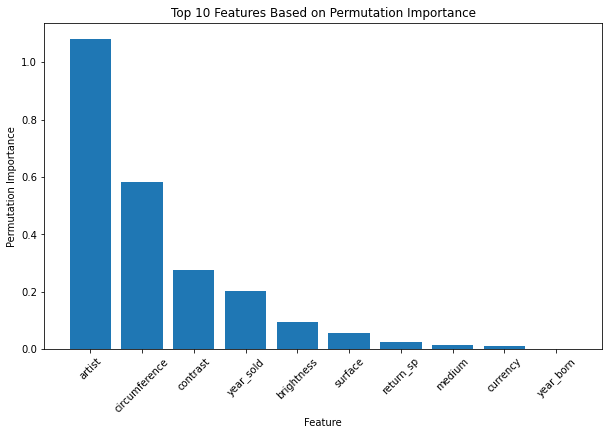

In [160]:
# Get the indices of the top 8 features
top_feature_indices_perm = feat_import_perm.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]

# Plotting the permutation importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names_perm)), feat_import_perm[top_feature_indices_perm], align="center")
plt.xticks(range(len(top_feature_names_perm)), top_feature_names_perm, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Top 10 Features Based on Permutation Importance")
plt.show()

* higher importance score
    * higher score = larger impact on the target, more influential in making predictions
* lower score
    * their permuation does not significantly affect the model's accuracy
* relative importance
    * the order of features in sorted list gives you an idea of which features arre most crucial for your model

In [161]:
# step 2: define a split point. We opt for 80%
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

x_test = test_set[top_feature_names_perm]
y_test = test_set['target']

one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'contrast', 'year_sold', 'brightness',
       'surface', 'return_sp', 'medium', 'currency', 'year_born'],
      dtype='object')


In [162]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
Best MSE: 1315173851286.0574
Cross-validation scores: [0.38499667 0.1497098  0.40659377 0.58708858 0.34645882]
Mean CV R-squared: 0.3749695311915306
training MAE: 21.015075048394472
Train R-squared: 0.9999999992333405
Training MSE: 1402.3691091528694
Training RMSE: 37.448219038465226


## test

In [163]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=20, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 12708659195145.51
Test RMSE: 3564920.6435972047
Test R-squared: 0.3060775583687564
Adjusted R2 is 0.26012242978390576
Test MAE: 1634988.280813204


## 8 Features

In [164]:
df.head(2)

,artist,contrast,brightness,year_sold,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


#### Random Forest

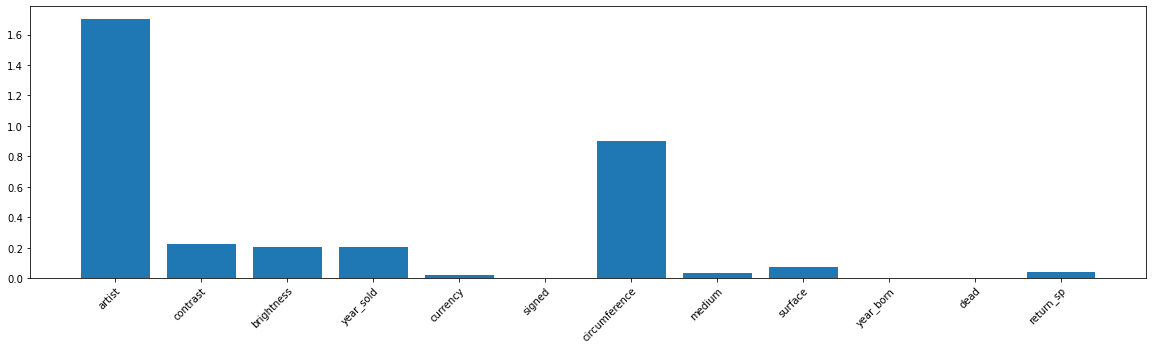

In [165]:
from sklearn.inspection import permutation_importance

estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_values, y_values)

perm_pipe = permutation_importance(pipeline, x_values, y_values, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_values.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

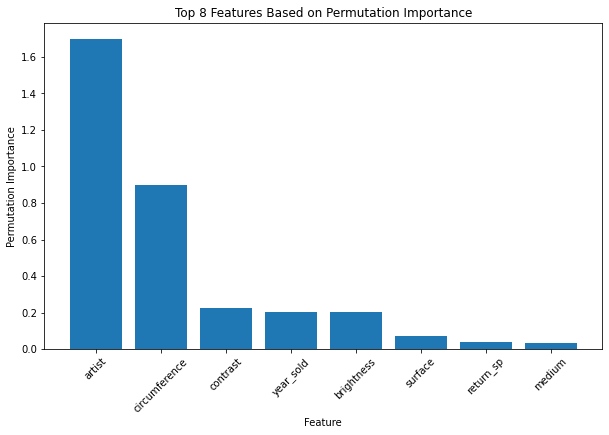

In [166]:
# Get the indices of the top 8 features
top_feature_indices_perm = feat_import_perm.argsort()[-8:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]

# Plotting the permutation importances for the top 8 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names_perm)), feat_import_perm[top_feature_indices_perm], align="center")
plt.xticks(range(len(top_feature_names_perm)), top_feature_names_perm, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Top 8 Features Based on Permutation Importance")
plt.show()

In [167]:
# step 2: define a split point. We opt for 80%
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-8:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'contrast', 'year_sold', 'brightness',
       'surface', 'return_sp', 'medium'],
      dtype='object')


In [168]:
# define the model that we are going to use
# we use the same random_state
# we are going to look what the best n_estimators is
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Best hyperparameters: {'estimator__max_depth': 20, 'estimator__n_estimators': 150}
Best MSE: 1373198030392.9392
Cross-validation scores: [-0.30366215  0.09283886  0.48285026  0.54405315  0.31266293]
Mean CV R-squared: 0.22574861224253717
Train R-squared: 0.9131693583907646
Train MSE: 158830108979.65024
Train RMSE: 398534.9532721694
Train MAE: 115424.88705614912


## test

In [169]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 11424257889586.299
Test RMSE: 3379978.977684077
Test R-squared: 0.376208866188267
Adjusted R2 is 0.33489819507490715
Test MAE: 1409083.276109454


#### Gradient Boosting

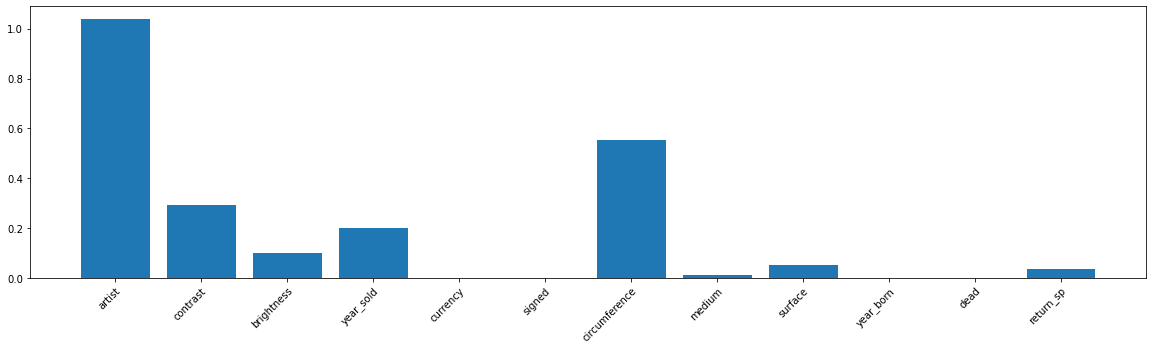

In [170]:
from sklearn.inspection import permutation_importance

estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_values, y_values)

perm_pipe = permutation_importance(pipeline, x_values, y_values, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_values.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

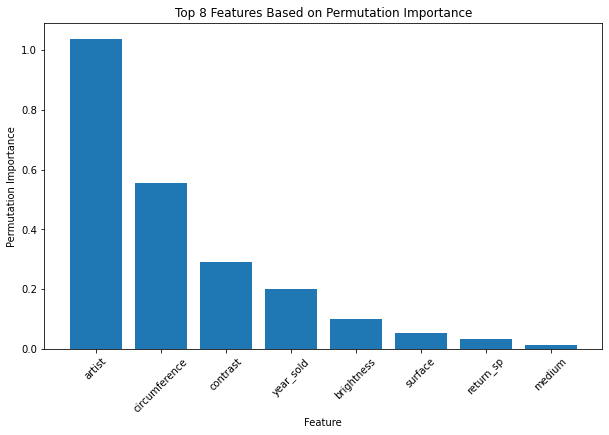

In [171]:
# Get the indices of the top 8 features
top_feature_indices_perm = feat_import_perm.argsort()[-8:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]

# Plotting the permutation importances for the top 8 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names_perm)), feat_import_perm[top_feature_indices_perm], align="center")
plt.xticks(range(len(top_feature_names_perm)), top_feature_names_perm, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Top 8 Features Based on Permutation Importance")
plt.show()

In [172]:
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-8:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'contrast', 'year_sold', 'brightness',
       'surface', 'return_sp', 'medium'],
      dtype='object')


In [173]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
Best MSE: 1394175578467.1743
Cross-validation scores: [0.30978833 0.06487539 0.38611091 0.53533244 0.3119405 ]
Mean CV R-squared: 0.32160951372315905
training MAE: 0.00039416477676918545
Train R-squared: 1.0
Training MSE: 9.189006710903663e-07
Training RMSE: 0.0009585930685595251


## test

In [174]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=2, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 12992850941333.16
Test RMSE: 3604559.743066157
Test R-squared: 0.2905600260014307
Adjusted R2 is 0.24357724626642618
Test MAE: 2485534.274295622


# Testing

## default dataset with Random Forest

In [175]:
df = dataframe

In [176]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,price_EUR,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [177]:
df.rename(columns={'price_EUR': 'target'}, inplace=True)

In [178]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [179]:
# step 1: sort your data in ascending order 'year_sold'
df = df.sort_values(by='year_sold')

# step 2: define a split point. We opt for 80%
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]


In [180]:
# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

In [181]:
# define the columns to encode and scale(min-max)
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [182]:
# define the final estimator with the best parameters
gbr = RandomForestRegressor(n_estimators=100, max_depth=20,random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('Random Forest')
print('')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Random Forest

Test MSE: 11003321795361.916
Test RMSE: 3317125.5320475763
Test R-squared: 0.3991929589859148
Adjusted R2 is 0.3464193675454883
Test MAE: 1534310.1636480307


### interpretability

In [183]:
one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed', 'dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

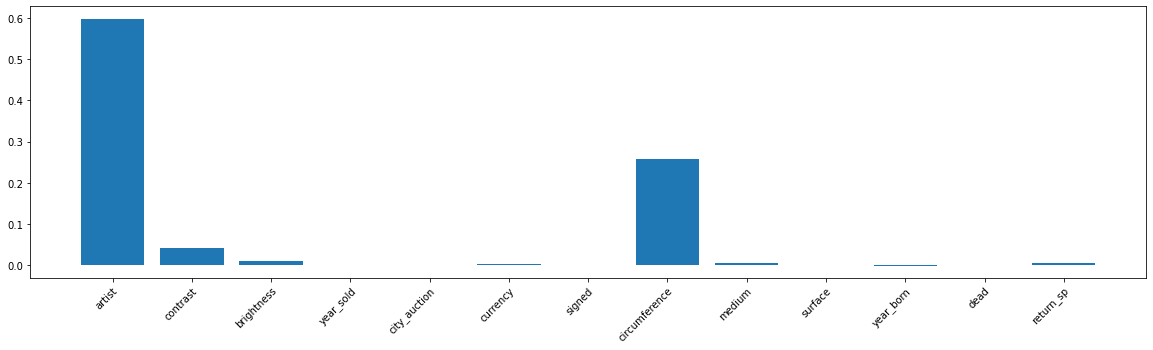

In [184]:
estimator = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_train, y_train)

perm_pipe = permutation_importance(pipeline, x_test, y_test, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_test.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [185]:
perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'Importance': perm_pipe.importances_mean})

# Sort the DataFrame by importance score in descending order
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(perm_importance_df)

          Feature  Importance
0          artist       0.598
7   circumference       0.258
1        contrast       0.041
2      brightness       0.010
12      return_sp       0.006
8          medium       0.004
5        currency       0.002
9         surface       0.001
6          signed       0.000
11           dead       0.000
3       year_sold       0.000
4    city_auction       0.000
10      year_born      -0.002


#### correlation with target/price

##### numerical

In [186]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
data_numerical = df[numerical_features]

# Calculate correlations with the target variable ("price")
correlation_with_price = data_numerical.corr()['target'].drop('target')

# Create a list of features ordered by their correlation with the target variable
ordered_features = correlation_with_price.abs().sort_values(ascending=False).index.tolist()

ordered_features_df = pd.DataFrame({
    'Feature': ordered_features,
    'Correlation with Price': [correlation_with_price[feature] for feature in ordered_features]
})

ordered_features_df_num = ordered_features_df.sort_values(by='Correlation with Price', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Price:")
print(ordered_features_df_num)

Ordered Features by Correlation with Price:
         Feature  Correlation with Price
0      year_sold                   0.217
1      year_born                   0.124
2  circumference                   0.109
5      return_sp                   0.040
4       contrast                  -0.053
3     brightness                  -0.109


##### categorical

In [187]:
categorical_features = df.select_dtypes(include=['object']).columns
data_categorical = df[categorical_features]

# One-hot encode categorical features
data_encoded = pd.get_dummies(data_categorical)

# Concatenate the encoded categorical features with numerical features
data_combined = pd.concat([data_encoded, data_numerical], axis=1)

# Calculate correlations with the target variable ("price")
correlation_with_price = data_combined.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df = pd.DataFrame({
    'Feature': correlation_with_price.index,
    'Correlation with Price': correlation_with_price.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df.sort_values(by='Correlation with Price', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Price:")
print(ordered_features_df_cat)

Ordered Features by Correlation with Price:
                            Feature  Correlation with Price
9              artist_Rene Magritte                   0.418
24                   surface_canvas                   0.233
30                        year_sold                   0.217
20       medium_Oil-Based Paintings                   0.188
32                        year_born                   0.124
31                    circumference                   0.109
12              city_auction_London                   0.100
13            city_auction_New York                   0.091
19                     currency_USD                   0.072
17                     currency_GBP                   0.054
33                        return_sp                   0.040
22           medium_Watercolour Art                   0.037
5     artist_Jan Breughel the elder                  -0.012
10     artist_Theo Van Rysselberghe                  -0.022
14               city_auction_Paris                  -0.

###### cat by cat

In [188]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'artist'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'artist':
                            Feature  Correlation with Target
9              artist_Rene Magritte                    0.418
5     artist_Jan Breughel the elder                   -0.012
10     artist_Theo Van Rysselberghe                   -0.022
3             artist_Jacob Jordaens                   -0.045
6   artist_Jan Breughel the younger                   -0.046
1       artist_Eugene Verboeckhoven                   -0.056
7               artist_Paul Delvaux                   -0.057
2              artist_Felicien Rops                   -0.058
0           artist_Anthony Van Dyck                   -0.075
4                artist_James Ensor                   -0.087
8          artist_Pierre Alechinsky                   -0.116


In [189]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'city_auction'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'city_auction':
                  Feature  Correlation with Target
1     city_auction_London                    0.100
2   city_auction_New York                    0.091
3      city_auction_Paris                   -0.042
0  city_auction_Amsterdam                   -0.101
4    city_auction_unknown                   -0.102


In [190]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'currency'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'currency':
        Feature  Correlation with Target
3  currency_USD                    0.072
1  currency_GBP                    0.054
2  currency_NLG                   -0.064
0  currency_EUR                   -0.101


In [191]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'signed'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'signed':
        Feature  Correlation with Target
1   signed_True                    0.135
0  signed_False                   -0.135


In [192]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
481,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
627,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [193]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'medium'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'medium':
                       Feature  Correlation with Target
0   medium_Oil-Based Paintings                    0.188
2       medium_Watercolour Art                    0.037
3               medium_missing                   -0.081
1  medium_Pen and Ink Drawings                   -0.172


In [194]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'surface'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'surface':
           Feature  Correlation with Target
0   surface_canvas                    0.233
2    surface_other                   -0.058
1  surface_missing                   -0.095
3    surface_paper                   -0.126


In [195]:
# Assuming df is your DataFrame, and 'target' is the target variable
categorical_feature = 'dead'

# Select the specific categorical feature and the target variable
data_subset = df[[categorical_feature, 'target']]

# One-hot encode the categorical feature
data_encoded = pd.get_dummies(data_subset)

# Calculate correlations with the target variable ("target")
correlation_with_target = data_encoded.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df_cat = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with Target': correlation_with_target.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df_cat = ordered_features_df_cat.sort_values(by='Correlation with Target', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Target for Categorical Feature '{}':".format(categorical_feature))
print(ordered_features_df_cat)

Ordered Features by Correlation with Target for Categorical Feature 'dead':
      Feature  Correlation with Target
1   dead_True                    0.116
0  dead_False                   -0.116


#### all in one

In [196]:
ordered_features_df_all = pd.concat([ordered_features_df_num, ordered_features_df])

# Sort the merged DataFrame by correlation scores in descending order
ordered_features_df_all = ordered_features_df_all.sort_values(by='Correlation with Price', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Price (Numerical + Categorical):")
print(ordered_features_df_all)

Ordered Features by Correlation with Price (Numerical + Categorical):
                            Feature  Correlation with Price
9              artist_Rene Magritte                   0.418
24                   surface_canvas                   0.233
0                         year_sold                   0.217
30                        year_sold                   0.217
20       medium_Oil-Based Paintings                   0.188
32                        year_born                   0.124
1                         year_born                   0.124
2                     circumference                   0.109
31                    circumference                   0.109
12              city_auction_London                   0.100
13            city_auction_New York                   0.091
19                     currency_USD                   0.072
17                     currency_GBP                   0.054
33                        return_sp                   0.040
5                         retu

## outlier-removed dataset (10 oultiers dropped) and Random Forest

In [197]:
df = df.reset_index(drop=True)

In [198]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [199]:
top_values_indices = df['target'].nlargest(10).index

In [200]:
split_percentage = 0.80
split_point = int(len(df) * split_percentage)

train_set = df[:split_point]
test_set = df[split_point:]

range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index <= range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

In [201]:
one_hot_cols = ['artist', 'city_auction', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [202]:
gbr = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 13009079939596.207
Test RMSE: 3606810.2167422404
Test R-squared: 0.2896738848336651
Adjusted R2 is 0.22728037471770324
Test MAE: 1765253.0979899238


## feature-selected dataset (10 features) and Random Forest

In [203]:
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [204]:
features_to_drop = ['signed','dead']
x_values = df.drop(columns=['target'] + features_to_drop)
y_values = df['target']

In [205]:
x_values.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,circumference,medium,surface,year_born,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,507.800,missing,canvas,1927,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,322.600,Watercolour Art,paper,1927,0.013


In [206]:
split_percentage = 0.80
split_point = int(len(df) * split_percentage) 

# Split the data in a training and test set
x_train = x_values[:split_point]
x_test = x_values[split_point:]

y_train = y_values[:split_point]
y_test = y_values[split_point:]

one_hot_cols = ['artist', 'currency', 'medium', 'surface']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [207]:
gbr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test MSE: 11038621020529.053
Test RMSE: 3322442.026661873
Test R-squared: 0.3972655389379346
Adjusted R2 is 0.3530650117933831
Test MAE: 1417378.706057924


### interpretability

In [208]:
one_hot_cols = ['artist', 'currency', 'medium', 'surface']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

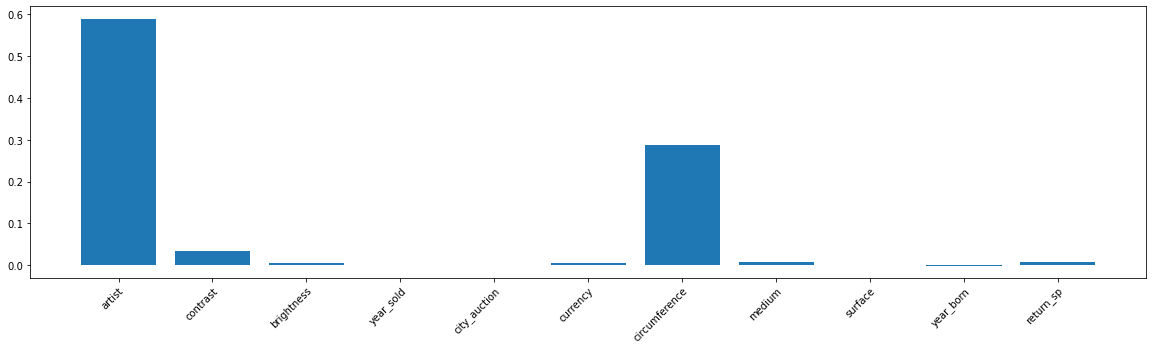

In [209]:
estimator = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_train, y_train)

perm_pipe = permutation_importance(pipeline, x_test, y_test, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_test.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [210]:
perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'Importance': perm_pipe.importances_mean})

# Sort the DataFrame by importance score in descending order
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(perm_importance_df)

          Feature  Importance
0          artist       0.590
6   circumference       0.287
1        contrast       0.034
7          medium       0.007
10      return_sp       0.007
5        currency       0.005
2      brightness       0.005
8         surface       0.000
3       year_sold       0.000
4    city_auction       0.000
9       year_born      -0.001


#### correlation with target / price

##### numerical

In [211]:
data = pd.concat([x_values, y_values], axis=1)

# Select non-categorical features (assuming numerical features)
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
data_numerical = data[numerical_features]

# Calculate correlations with the target variable ("price")
correlation_with_price = data_numerical.corr()['target'].drop('target')

# Create a list of features ordered by their correlation with the target variable
ordered_features = correlation_with_price.abs().sort_values(ascending=False).index.tolist()

ordered_features_df = pd.DataFrame({
    'Feature': ordered_features,
    'Correlation with Price': [correlation_with_price[feature] for feature in ordered_features]
})

ordered_features_df = ordered_features_df.sort_values(by='Correlation with Price', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Price:")
print(ordered_features_df)

Ordered Features by Correlation with Price:
         Feature  Correlation with Price
0      year_sold                   0.217
1      year_born                   0.124
2  circumference                   0.109
5      return_sp                   0.040
4       contrast                  -0.053
3     brightness                  -0.109


##### categorical

In [212]:
data = pd.concat([x_values, y_values], axis=1)

# Select categorical features (assuming object type)
categorical_features = data.select_dtypes(include=['object']).columns
data_categorical = data[categorical_features]

# One-hot encode categorical features
data_encoded = pd.get_dummies(data_categorical)

# Concatenate the encoded categorical features with numerical features
data_combined = pd.concat([data_encoded, data_numerical], axis=1)

# Calculate correlations with the target variable ("price")
correlation_with_price = data_combined.corr()['target'].drop('target')

# Create a DataFrame with feature names and their correlation scores
ordered_features_df = pd.DataFrame({
    'Feature': correlation_with_price.index,
    'Correlation with Price': correlation_with_price.values
})

# Sort the DataFrame by correlation scores in descending order
ordered_features_df = ordered_features_df.sort_values(by='Correlation with Price', ascending=False)

# Display the ordered list of features with correlation scores
print("Ordered Features by Correlation with Price:")
print(ordered_features_df)

Ordered Features by Correlation with Price:
                            Feature  Correlation with Price
9              artist_Rene Magritte                   0.418
24                   surface_canvas                   0.233
30                        year_sold                   0.217
20       medium_Oil-Based Paintings                   0.188
32                        year_born                   0.124
31                    circumference                   0.109
12              city_auction_London                   0.100
13            city_auction_New York                   0.091
19                     currency_USD                   0.072
17                     currency_GBP                   0.054
33                        return_sp                   0.040
22           medium_Watercolour Art                   0.037
5     artist_Jan Breughel the elder                  -0.012
10     artist_Theo Van Rysselberghe                  -0.022
14               city_auction_Paris                  -0.

# Not important anymore

## Feature painting or drawing instead of surface and medium

In [213]:
dfx = dataframe
dfx = dfx.rename(columns={'price_EUR': 'target'})
dfx.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259


In [214]:
# making from medium and surface one boolean --> drawing or painting
dfx['painting_drawing'] = 0
dfx.loc[(dfx['medium'] == 'Pen and Ink Drawings') | (dfx['surface'] == 'paper'), 'painting_drawing'] = 'drawing'
dfx.loc[dfx['medium'] == 'Oil-Based Paintings', 'painting_drawing'] = 'painting'
for index, row in dfx.iterrows():
    if row['painting_drawing']==0:
        dfx.at[index, 'painting_drawing'] = 'painting'
dfx.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp,painting_drawing
0,Pierre Alechinsky,52.601,101.140,2018,Amsterdam,EUR,87500.000,True,536.000,missing,canvas,1927,False,0.216,painting
1,Theo Van Rysselberghe,49.258,136.516,2010,Paris,EUR,79000.000,True,243.600,Oil-Based Paintings,canvas,1862,True,0.259,painting


In [215]:
# Assuming 'dfx' is your DataFrame
# Count the occurrences of the value 0 in the 'painting_drawing' column
count_0 = (dfx['painting_drawing'] == 0).sum()

# Display the count of occurrences of the value 0
print("Number of occurrences of 0 in 'painting_drawing':", count_0)

Number of occurrences of 0 in 'painting_drawing': 0


In [216]:
painting_drawing_stats = dfx.groupby('painting_drawing').agg({'painting_drawing': 'count', 'target': 'sum'})

# Renaming columns for clarity
painting_drawing_stats = painting_drawing_stats.rename(columns={'painting_drawing': 'count', 'target': 'total_spent'})
painting_drawing_stats['average'] = painting_drawing_stats['total_spent']/painting_drawing_stats['count']
painting_drawing_stats = painting_drawing_stats.sort_values(by='average', ascending=False)
print(painting_drawing_stats)

                  count   total_spent    average
painting_drawing                                
painting            471 451180920.260 957921.274
drawing             338  73591598.350 217726.622


In [217]:
dfx = dfx.drop(['medium','surface'], axis=1)
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 809 entries, 0 to 810
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   artist            809 non-null    object  
 1   contrast          809 non-null    float64 
 2   brightness        809 non-null    float64 
 3   year_sold         809 non-null    int64   
 4   city_auction      809 non-null    object  
 5   currency          809 non-null    object  
 6   target            809 non-null    float64 
 7   signed            809 non-null    category
 8   circumference     809 non-null    float64 
 9   year_born         809 non-null    int64   
 10  dead              809 non-null    category
 11  return_sp         809 non-null    float64 
 12  painting_drawing  809 non-null    object  
dtypes: category(2), float64(5), int64(2), object(4)
memory usage: 109.9+ KB


In [218]:
dfx = dfx.sort_values(by='year_sold')

split_percentage = 0.80
split_point = int(len(dfx) * split_percentage)

# step 3: Split the data in a training and test set
train_set = dfx[:split_point]
test_set = dfx[split_point:]

# Check the time range in each set
print("Training Set Time Range:", train_set['year_sold'].min(), train_set['year_sold'].max())
print("Testing Set Time Range:", test_set['year_sold'].min(), test_set['year_sold'].max())

Training Set Time Range: 1994 2019
Testing Set Time Range: 2019 2023


In [219]:
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

In [220]:
one_hot_cols = ['artist', 'city_auction', 'currency', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

##### random forest

In [221]:
print('Random Forest')
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Random Forest
Best hyperparameters: {'estimator__max_depth': None, 'estimator__n_estimators': 100}
Best MSE: 1365738151089.2837
Cross-validation scores: [-0.66363448  0.11147638  0.44058487  0.56848465  0.3276824 ]
Mean CV R-squared: 0.15691876490421822
Train R-squared: 0.9083418701817938
Train MSE: 167660522576.9541
Train RMSE: 409463.7011713665
Train MAE: 121249.35655239565


##### gradient boosting

In [222]:
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [1,3,5 ,7, 10],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting
Best Hyperparameters: {'estimator__max_depth': 7, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
Best MSE: 1387808718665.7866
Cross-validation scores: [0.37753583 0.06764133 0.33369454 0.53298568 0.32696073]
Mean CV R-squared: 0.3277636223740895
training MAE: 3774.4446323530237
Train R-squared: 0.9999789811546217
Training MSE: 38447550.774699755
Training RMSE: 6200.608903543244


###### test

In [223]:
gbr = RandomForestRegressor(n_estimators=100, max_depth=20,random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('test Random Forest')
print('')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

test Random Forest

Test MSE: 10831572686651.879
Test RMSE: 3291135.4707231177
Test R-squared: 0.4085708610158617
Adjusted R2 is 0.36093898405069624
Test MAE: 1519436.0995665775


In [224]:
gbr = GradientBoostingRegressor(n_estimators=50, max_depth=7, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('test Gradient Boosting')
print('')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

test Gradient Boosting

Test MSE: 14098741249734.092
Test RMSE: 3754829.057325259
Test R-squared: 0.23017583509677275
Adjusted R2 is 0.1681765734938283
Test MAE: 1501586.5081748643


# combination model

In [225]:
# combination of all these models: --> drop 10 outlier and 8 features 
df.head(2)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,medium,surface,year_born,dead,return_sp
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,missing,canvas,1927,False,0.100
1,Pierre Alechinsky,62.101,174.389,1995,New York,USD,9730.240,True,322.600,Watercolour Art,paper,1927,False,0.013


In [226]:
df = df.sort_values(by='year_sold')

split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

# Check the time range in each set
print("Training Set Time Range:", train_set['year_sold'].min(), train_set['year_sold'].max())
print("Testing Set Time Range:", test_set['year_sold'].min(), test_set['year_sold'].max())

Training Set Time Range: 1994 2019
Testing Set Time Range: 2019 2023


In [227]:
df = df.reset_index(drop=True)

In [228]:
top_values_indices = df['target'].nlargest(10).index

In [229]:
range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index < range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

In [230]:
one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [231]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Best hyperparameters: {'estimator__max_depth': None, 'estimator__n_estimators': 100}
Best MSE: 1293851254761.2239
Cross-validation scores: [0.01290975 0.08789117 0.51473599 0.58185512 0.29168481]
Mean CV R-squared: 0.2978153702217027
Train R-squared: 0.9063797666990207
Train MSE: 161731687360.20584
Train RMSE: 402158.7837660715
Train MAE: 117660.39956728685


In [232]:
gbr = RandomForestRegressor(n_estimators=25, max_depth=15, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('test Random Forest')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

test Random Forest
Test MSE: 12036041912156.088
Test RMSE: 3469299.9167203875
Test R-squared: 0.3527018115239764
Adjusted R2 is 0.29584453821189327
Test MAE: 1460007.1512764744


In [233]:
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting
Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 100}
Best MSE: 1282233808182.0813
Cross-validation scores: [0.26427453 0.06583477 0.42044698 0.59963287 0.31617049]
Mean CV R-squared: 0.3332719276892556
training MAE: 1433.5125013533993
Train R-squared: 0.99999658106246
Training MSE: 5906314.4559074165
Training RMSE: 2430.2910228833534


In [234]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=10, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('Test Gradient Boosting')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test Gradient Boosting
Test MSE: 15057081288228.207
Test RMSE: 3880345.511449748
Test R-squared: 0.19023035041422398
Adjusted R2 is 0.11910193524790569
Test MAE: 1611369.0021174154


# feature painting _ drawing and 10 dropping features 

In [235]:
dfx.head(1)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,year_born,dead,return_sp,painting_drawing
481,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,1927,False,0.100,painting


In [236]:
dfx = dfx.reset_index(drop=True)

In [237]:
dfx.head(1)

,artist,contrast,brightness,year_sold,city_auction,currency,target,signed,circumference,year_born,dead,return_sp,painting_drawing
0,Pierre Alechinsky,72.213,133.827,1994,London,GBP,40694.870,True,507.800,1927,False,0.100,painting


In [238]:
split_percentage = 0.80
split_point = int(len(dfx) * split_percentage)

# step 3: Split the data in a training and test set
train_set = dfx[:split_point]
test_set = dfx[split_point:]

# Check the time range in each set
print("Training Set Time Range:", train_set['year_sold'].min(), train_set['year_sold'].max())
print("Testing Set Time Range:", test_set['year_sold'].min(), test_set['year_sold'].max())

Training Set Time Range: 1994 2019
Testing Set Time Range: 2019 2023


In [239]:
top_values_indices = dfx['target'].nlargest(10).index

In [240]:
range_train = len(train_set)

filtered_indices = [index for index in top_values_indices if index < range_train]

# splitting the training set into features X and target variable Y
x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

# dropping the rows based on the indices
x_train = x_train.drop(index=filtered_indices)
y_train = y_train.drop(index=filtered_indices)

#splitting the test set into  features X and target variable Y
x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

In [241]:
one_hot_cols = ['artist', 'currency', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [242]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
print('random forest')

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

random forest
Best hyperparameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 200}
Best MSE: 557186490150.9854
Cross-validation scores: [-0.62919442  0.05313063  0.50760975  0.57468912  0.37328018]
Mean CV R-squared: 0.17590305354726932
Train R-squared: 0.9232996688564543
Train MSE: 64563812317.339355
Train RMSE: 254094.10130370865
Train MAE: 111250.12461783602


In [243]:
gbr = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('test Random Forest')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

test Random Forest
Test MSE: 13164963160883.643
Test RMSE: 3628355.434750521
Test R-squared: 0.2811622972724501
Adjusted R2 is 0.22326932792526488
Test MAE: 1948115.6631609227


In [244]:
estimator = GradientBoostingRegressor(random_state=42)
print('Gradient Boosting')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Gradient Boosting
Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
Best MSE: 548230724587.79755
Cross-validation scores: [0.32429918 0.01916662 0.45849791 0.62196203 0.34195492]
Mean CV R-squared: 0.35317613176178997
training MAE: 1.877208442899388
Train R-squared: 0.9999999986503768
Training MSE: 1136.0683322809832
Training RMSE: 33.70561277118372


In [245]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=10, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('Test Gradient Boosting')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

Test Gradient Boosting
Test MSE: 13685095856004.938
Test RMSE: 3699337.218476431
Test R-squared: 0.25276183863801926
Adjusted R2 is 0.19258158403168524
Test MAE: 2025520.7734119936


## less features

#### random forest

In [246]:
one_hot_cols = ['artist', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('num', continuous_transformer, continuous_cols)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

In [247]:
# splitting data in X and y dataset 
x_values = dfx.drop(columns=['target'])
y_values = dfx['target']

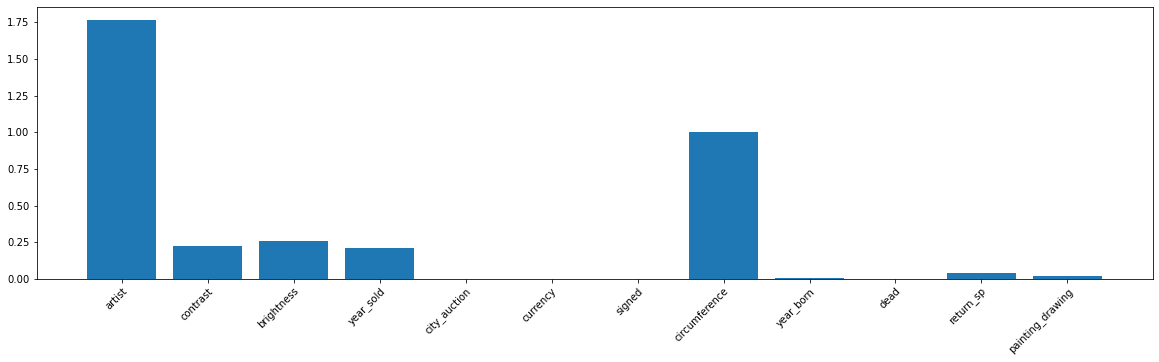

In [248]:
from sklearn.inspection import permutation_importance

estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_values, y_values)

perm_pipe = permutation_importance(pipeline, x_values, y_values, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_values.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

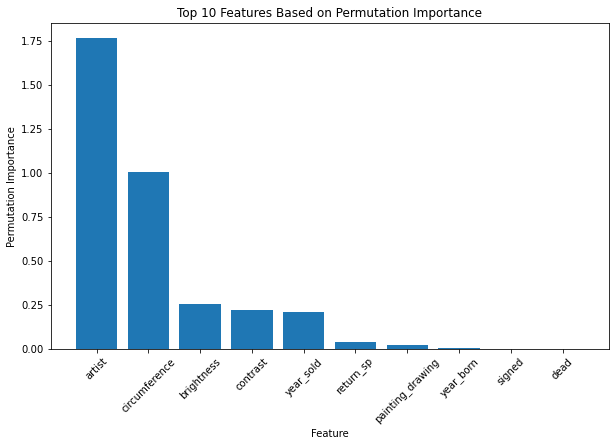

In [249]:
# Get the indices of the top 8 features
top_feature_indices_perm = feat_import_perm.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]

# Plotting the permutation importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names_perm)), feat_import_perm[top_feature_indices_perm], align="center")
plt.xticks(range(len(top_feature_names_perm)), top_feature_names_perm, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Top 10 Features Based on Permutation Importance")
plt.show()

In [250]:
split_percentage = 0.80
split_point = int(len(dfx) * split_percentage)

# step 3: Split the data in a training and test set
train_set = dfx[:split_point]
test_set = dfx[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

x_test = test_set[top_feature_names_perm]
y_test = test_set['target']

one_hot_cols = ['artist', 'currency', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'brightness', 'contrast', 'year_sold',
       'return_sp', 'painting_drawing', 'year_born', 'signed', 'dead'],
      dtype='object')


In [251]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Best hyperparameters: {'estimator__max_depth': 20, 'estimator__n_estimators': 10}
Best MSE: 1380499277846.7234
Cross-validation scores: [-1.21476911  0.05565081  0.35772474  0.49528961  0.36233966]
Mean CV R-squared: 0.011247140666900579
Train R-squared: 0.8506930803080323
Train MSE: 273111356620.09003
Train RMSE: 522600.5708187564
Train MAE: 131721.017604793


In [252]:
gbr = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('test random forest')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

test random forest
Test MSE: 10677366571921.754
Test RMSE: 3267623.9948809524
Test R-squared: 0.4169908746463218
Adjusted R2 is 0.3783809987950848
Test MAE: 1481245.603236021


# 8

In [253]:
split_percentage = 0.80
split_point = int(len(dfx) * split_percentage)

# step 3: Split the data in a training and test set
train_set = dfx[:split_point]
test_set = dfx[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-8:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

x_test = test_set[top_feature_names_perm]
y_test = test_set['target']

one_hot_cols = ['artist', 'currency', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'brightness', 'contrast', 'year_sold',
       'return_sp', 'painting_drawing', 'year_born'],
      dtype='object')


In [254]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# define the grid of hyperparamters to look at
param_grid = {
    'estimator__n_estimators': [10, 25, 50, 100, 150, 200],
    'estimator__max_depth': [None,5, 10, 15, 20, 30]
}

# define the grid search object
time_serie_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_serie_split, scoring='neg_mean_squared_error')

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_serie_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# fit the pipeline to the train data
grid_search.best_estimator_.fit(x_train, y_train)

# make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# print the R-squared score of the model on the train data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# print the mean squared error of the model on the train data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", mse_train)

# print the root mean squared error of the model on the train data
rmse_train = mse_train ** 0.5
print("Train RMSE:", rmse_train)

# Calculate and print the Mean Absolute Error (MAE) of the model on the train data
mae_train = mean_absolute_error(y_train, y_pred_train)
print("Train MAE:", mae_train)

Best hyperparameters: {'estimator__max_depth': 10, 'estimator__n_estimators': 150}
Best MSE: 1386208295100.3652
Cross-validation scores: [-0.59459221  0.06931713  0.46711942  0.53537825  0.31528748]
Mean CV R-squared: 0.1585020150185372
Train R-squared: 0.909626400574294
Train MSE: 165310866989.39508
Train RMSE: 406584.39098100545
Train MAE: 131167.9166542725


In [255]:
gbr = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('test random forest')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

test random forest
Test MSE: 10990242774005.59
Test RMSE: 3315153.5068538818
Test R-squared: 0.39990710406560936
Adjusted R2 is 0.36852969774224253
Test MAE: 1451499.2023874428


### gradient boosting

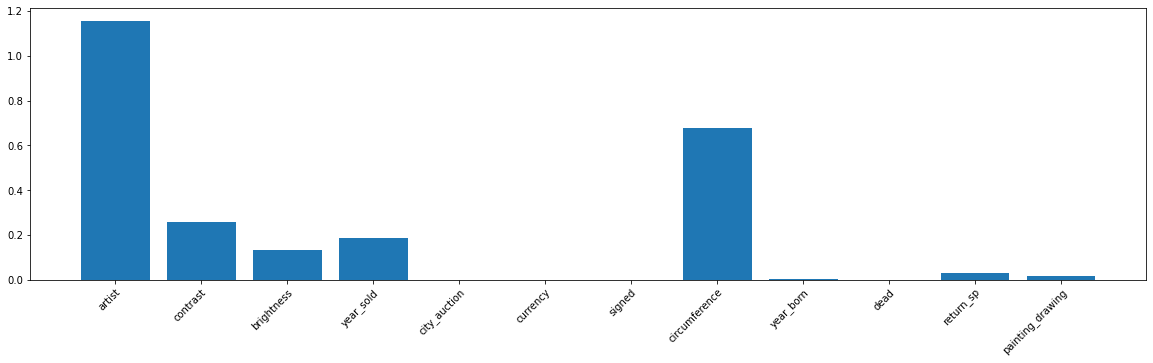

In [256]:
estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

pipeline.fit(x_values, y_values)

perm_pipe = permutation_importance(pipeline, x_values, y_values, n_repeats=100, random_state=42, n_jobs=-1)

feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=x_values.columns)
# Set properties of x axis using setp, we will rotate the labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

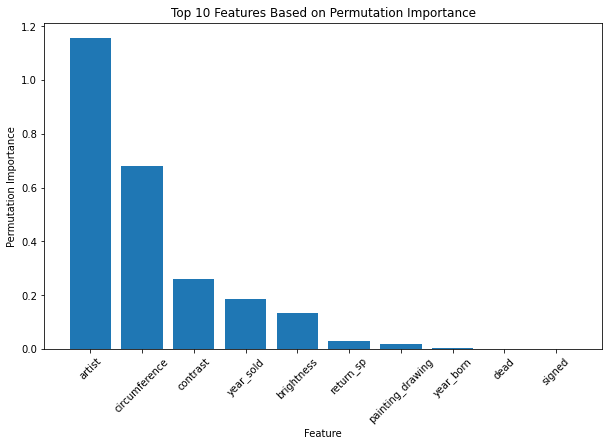

In [257]:
top_feature_indices_perm = feat_import_perm.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]

# Plotting the permutation importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names_perm)), feat_import_perm[top_feature_indices_perm], align="center")
plt.xticks(range(len(top_feature_names_perm)), top_feature_names_perm, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Top 10 Features Based on Permutation Importance")
plt.show()

In [258]:
split_percentage = 0.80
split_point = int(len(dfx) * split_percentage)

# step 3: Split the data in a training and test set
train_set = dfx[:split_point]
test_set = dfx[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-10:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

x_test = test_set[top_feature_names_perm]
y_test = test_set['target']

one_hot_cols = ['artist', 'currency', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'contrast', 'year_sold', 'brightness',
       'return_sp', 'painting_drawing', 'year_born', 'dead', 'signed'],
      dtype='object')


In [259]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
Best MSE: 1306616438186.4478
Cross-validation scores: [0.02935968 0.08649929 0.45286066 0.52633709 0.36429123]
Mean CV R-squared: 0.29186959075874214
training MAE: 0.00038902389825103584
Train R-squared: 1.0
Training MSE: 9.116887079148081e-07
Training RMSE: 0.000954823914611908


In [260]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=10, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('tets gradient boosting')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

tets gradient boosting
Test MSE: 10944990389993.062
Test RMSE: 3308321.3855357314
Test R-squared: 0.4023779898074824
Adjusted R2 is 0.3628003732384415
Test MAE: 1570933.1485898958


# 8

In [261]:
split_percentage = 0.80
split_point = int(len(dfx) * split_percentage)

# step 3: Split the data in a training and test set
train_set = dfx[:split_point]
test_set = dfx[split_point:]

# Get the indices of the top 8 features
top_feature_indices_perm = perm_pipe.importances_mean.argsort()[-8:][::-1]

# Get the names of the top 8 features
top_feature_names_perm = x_values.columns[top_feature_indices_perm]
print(top_feature_names_perm)

# splitting in training set X and training set y but now only with the features we want.
x_train = train_set[top_feature_names_perm]
y_train = train_set['target']

x_test = test_set[top_feature_names_perm]
y_test = test_set['target']

one_hot_cols = ['artist', 'currency', 'painting_drawing', 'signed','dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# define the columns to encode and scale (standard)
one_hot_cols_less_features = [col for col in one_hot_cols if col in top_feature_names_perm]
continuous_cols_less_features = [col for col in continuous_cols if col in top_feature_names_perm]

# define the transformers for each column type
one_hot_transformer = ce.OneHotEncoder(cols=one_hot_cols_less_features)
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols_less_features),
        ('num', continuous_transformer, continuous_cols_less_features)],
    )

# define the feature selector
selector = SelectKBest(score_func=f_regression, k="all")

Index(['artist', 'circumference', 'contrast', 'year_sold', 'brightness',
       'return_sp', 'painting_drawing', 'year_born'],
      dtype='object')


In [262]:
# Define the estimator for Gradient Boosting
estimator = GradientBoostingRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', estimator)
])

# Define the hyperparameters to tune
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [7, 10, 20],
    'estimator__max_features': ['sqrt', 'log2'],
}

# Create a grid search object
time_series_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best MSE and corresponding negative value
best_mse = -grid_search.best_score_
print("Best MSE:", best_mse)

# Calculate and print the cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=time_series_split, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV R-squared:", cv_scores.mean())

# calculate and print MAE
mae = mean_absolute_error(y_train, grid_search.best_estimator_.predict(x_train))
print('training MAE:', mae)

# Make predictions using the fitted pipeline on the train data
y_pred_train = grid_search.best_estimator_.predict(x_train)

# Print the R-squared score of the model on the training data
print("Train R-squared:", grid_search.best_estimator_.score(x_train, y_train))

# Print the mean squared error of the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
print("Training MSE:", mse_train)

# Print the root mean squared error of the model on the training data
rmse_train = sqrt(mse_train)
print("Training RMSE:", rmse_train)

Best Hyperparameters: {'estimator__max_depth': 7, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
Best MSE: 1370961587645.0222
Cross-validation scores: [-0.36726615  0.04846453  0.38345372  0.50431102  0.3476067 ]
Mean CV R-squared: 0.18331396271695
training MAE: 3461.4295716698825
Train R-squared: 0.9999851181206624
Training MSE: 27221847.877848923
Training RMSE: 5217.4560733990775


In [263]:
# define the final estimator with the best parameters
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=20, max_features= 'sqrt',random_state=42)

# define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('estimator', gbr)])

# fit the pipeline to the training data
pipeline.fit(x_train, y_train)

# make predictions on the test set
y_pred = pipeline.predict(x_test)

# evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = pipeline.score(x_test, y_test)
adj_r2 = 1 - ((1 - r2) * (x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1))
mae = mean_absolute_error(y_test, y_pred)

print('tets gradient boosting')
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print('Adjusted R2 is', adj_r2)
print("Test MAE:", mae)

tets gradient boosting
Test MSE: 11682967524751.102
Test RMSE: 3418035.6236808156
Test R-squared: 0.3620827165331041
Adjusted R2 is 0.3287275644564036
Test MAE: 1504138.0660284592


# Neural Network

In [264]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, initializers, regularizers, losses, callbacks, optimizers
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [265]:
one_hot_cols = ['artist', 'currency', 'medium', 'surface', 'signed', 'dead']
continuous_cols = ['contrast', 'brightness', 'year_sold', 'circumference', 'year_born', 'return_sp']

# Create preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continuous_cols),
        ('cat', categorical_transformer, one_hot_cols)
    ])

split_percentage = 0.80
split_point = int(len(df) * split_percentage)

# step 3: Split the data in a training and test set
train_set = df[:split_point]
test_set = df[split_point:]

x_train = train_set.drop(columns=['target'])
y_train = train_set['target']

x_test = test_set.drop(columns=['target'])
y_test = test_set['target']

# create a scaler for the target feature
scaler = MinMaxScaler()

y_train_array = np.array(y_train).reshape(-1, 1)
y_test_array = np.array(y_test).reshape(-1, 1)

y_train_scaled = scaler.fit_transform(y_train_array).flatten()
y_test_scaled = scaler.transform(y_test_array).flatten()

# Apply the preprocessing pipeline to your data
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

Epoch 1/50
21/21 [==============================] - 1s 12ms/step - loss: 5.0570 - mae: 0.5079 - val_loss: 5.0119 - val_mae: 0.4532
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 5.0581 - mae: 0.5089 - val_loss: 5.0119 - val_mae: 0.4532
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 5.0576 - mae: 0.5084 - val_loss: 5.0119 - val_mae: 0.4532
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 5.0583 - mae: 0.5092 - val_loss: 5.0119 - val_mae: 0.4532
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 5.0570 - mae: 0.5081 - val_loss: 5.0119 - val_mae: 0.4532
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 5.0601 - mae: 0.5112 - val_loss: 5.0119 - val_mae: 0.4532


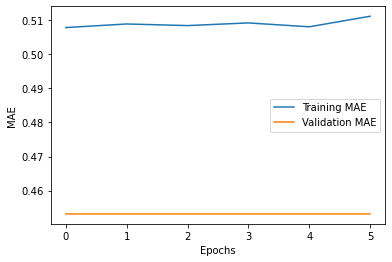

In [266]:
# Build the neural network model
model = Sequential([
    layers.Input(shape=(33,)),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

# Set your desired learning rate
learning_rate = 0.0000000001  # You can adjust this value

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
# Train the model with MAE monitoring and early stopping
history = model.fit(
    x_train_processed, y_train_scaled,
    epochs=50,
    validation_data=(x_test_processed, y_test_scaled),
    callbacks=[early_stopping]
)

# Get MAE values from the training history
mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot MAE values over epochs
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [267]:
%lsmagic
%history -n


   1:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import requests
warnings.filterwarnings("ignore")
   2:
df = pd.read_csv('dataset_twee.csv')
df.head(2)
   3:
# dropping the duplicates
df = df.drop_duplicates()
   4:
# looking how much different artists we have to work with
artist_freq = df['artist'].value_counts()
print(f"There are {len(artist_freq)} different artists in {len(df)} samples and the frequency of each different artist is:")
print(artist_freq)
   5:
# some painters are the same and we are going to put them under one name 
replace_artists = {'Jan Breughel I': 'Jan Breughel the elder', 'Jan Breughel II': 'Jan Breughel the younger', 'Rysselberghe': 'Theo Van Rysselberghe'}
df['artist'] = df['artist'].replace(replace_artists)

# drop all the columns with Breughel because we dont know which one it is ( there are more Breughels such as Pieter B. the younger and elder, ...)
df = df[df['artist'] != 'Breugh